In [2]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
import copy
import netCDF4 as nc4
# from mpl_toolkits.basemap import Basemap, cm, shiftgrid, maskoceans
import cartopy.crs as ccrs
from matplotlib import ticker, cm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
# Global grid area for 0.5 deg 
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
earth_area = 5.096e14
lat = np.arange(-89.75, 90.25, 0.5)
res = 2;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

### Use NetCDF4 to open dataset

In [4]:
## Inputs from user
## Some constants
yr_beg = 1850
nyr = 160
nlat = 46
nlon = 72

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
# filename_in = 'fates.nor_spinup.elm.h0.1850_2000.nc'
filename_in = 'fates.normal_spinup.fixedbg_highvmax.elm.h0.1850_2009.compressed.nc'
# filename_in = 'fates.normal_spinup.nocomp.elm.h0.1850_2009.compressed.nc'

## Do not modify the following
## Spinup history
# Monthly mean output
ds = nc4.Dataset(filename_in)

## read in variables
## Macro-ecology
soilc = ds['SOILC'][:]
vegc = ds['FATES_VEGC'][:]
litterc = ds['LITTERC'][:]
vegc_pf = ds['FATES_VEGC_PF'][:]
area_plants = ds['FATES_AREA_PLANTS'][:]
structc = ds['FATES_STRUCTC'][:]
nonstructc = ds['FATES_NONSTRUCTC'][:]
leafc = ds['FATES_LEAFC'][:]

# C fluxes
gpp = ds['FATES_GPP'][:]
gpp_pf = ds['FATES_GPP_PF'][:]
npp = ds['FATES_NPP'][:]
nep = ds['FATES_NEP'][:]
nbp = ds['NBP'][:]
hr = ds['FATES_HET_RESP'][:]
litc_in = ds['FATES_LITTER_IN'][:]
litc_out = ds['FATES_LITTER_OUT'][:]

## Micro-ecology
# Nplant
np_pf = ds['FATES_NPLANT_PF'][:]
np_sz = ds['FATES_NPLANT_SZ'][:]

# Recruitment
recru_pf = ds['FATES_RECRUITMENT_PF'][:]

# Germinated Seed
sg = ds['FATES_SEED_GERM_EL'][:]

# Crown area to calculate dominant PFT
cr_area_pf = ds['FATES_CROWNAREA_PF'][:]

# Mortality (Commneted mortalities are all zeros)
age_mort = ds['FATES_MORTALITY_AGESCEN_SZ'][:]
back_mort = ds['FATES_MORTALITY_BACKGROUND_SZ'][:]
starv_mort = ds['FATES_MORTALITY_CSTARV_SZ'][:]
# fire_mort = ds['FATES_MORTALITY_FIRE_SZ'][:]
freeze_mort = ds['FATES_MORTALITY_FREEZING_SZ'][:]
hydra_mort = ds['FATES_MORTALITY_HYDRAULIC_SZ'][:]
# impact_mort = ds['FATES_MORTALITY_IMPACT_SZ'][:]
# logging_mort = ds['FATES_MORTALITY_LOGGING_SZ'][:]
scene_mort = ds['FATES_MORTALITY_SENESCENCE_SZ'][:]
# termi_mort = ds['FATES_MORTALITY_TERMINATION_SZ'][:]

# # No-comp mode only, please comment this out if not no-comp mode result
# area_pf_nocomp = ds['FATES_NOCOMP_PATCHAREA_PF'][:]

ds.close()

# Auxiliary data: land use time series
## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
lat_4x5 = latnc
lon_4x5 = lonnc

C:\Users\sshu3\Anaconda2\lib\site-packages\scipy\io\netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


### NetCDF3 version

In [ ]:
############################################################
### Diagnosis of transient case
############################################################

## Inputs from user
## Some constants
yr_beg = 1850
nyr = 160
nlat = 46
nlon = 72

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
# filename_in = 'fates.nor_spinup.elm.h0.1850_2000.nc'
filename_in = 'fates.normal_spinup.fixedbg.elm.h0.1850_2009.compressed.nc'

## Do not modify the following
## Spinup history
# Monthly mean output
fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years

## define the sizes of each dimension
ntim = len(time)

## read in variables
## Macro-ecology
soilc = fin.variables['SOILC'][:]
vegc = fin.variables['FATES_VEGC'][:]
litterc = fin.variables['LITTERC'][:]
vegc_pf = fin.variables['FATES_VEGC_PF'][:]
area_plants = fin.variables['FATES_AREA_PLANTS'][:]
structc = fin.variables['FATES_STRUCTC'][:]
nonstructc = fin.variables['FATES_NONSTRUCTC'][:]
leafc = fin.variables['FATES_LEAFC'][:]
# vegc_age = fin.variables['FATES_VEGC_AP'][:]

# C fluxes
gpp = fin.variables['FATES_GPP'][:]
npp = fin.variables['FATES_NPP'][:]
nep = fin.variables['FATES_NEP'][:]
nbp = fin.variables['NBP'][:]
hr = fin.variables['FATES_HET_RESP'][:]
litc_in = fin.variables['FATES_LITTER_IN'][:]
litc_out = fin.variables['FATES_LITTER_OUT'][:]

## Micro-ecology
# Nplant
np_pf = fin.variables['FATES_NPLANT_PF'][:]
np_sz = fin.variables['FATES_NPLANT_SZ'][:]

# Recruitment
recru_pf = fin.variables['FATES_RECRUITMENT_PF'][:]

# Germinated Seed
sg = fin.variables['FATES_SEED_GERM_EL'][:]

# Mortality (Commneted mortalities are all zeros)
age_mort = fin.variables['FATES_MORTALITY_AGESCEN_SZ'][:]
back_mort = fin.variables['FATES_MORTALITY_BACKGROUND_SZ'][:]
starv_mort = fin.variables['FATES_MORTALITY_CSTARV_SZ'][:]
# fire_mort = fin.variables['FATES_MORTALITY_FIRE_SZ'][:]
freeze_mort = fin.variables['FATES_MORTALITY_FREEZING_SZ'][:]
hydra_mort = fin.variables['FATES_MORTALITY_HYDRAULIC_SZ'][:]
# impact_mort = fin.variables['FATES_MORTALITY_IMPACT_SZ'][:]
# logging_mort = fin.variables['FATES_MORTALITY_LOGGING_SZ'][:]
scene_mort = fin.variables['FATES_MORTALITY_SENESCENCE_SZ'][:]
# termi_mort = fin.variables['FATES_MORTALITY_TERMINATION_SZ'][:]

fin.close()

# Auxiliary data: land use time series
## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
lat_4x5 = latnc
lon_4x5 = lonnc


In [4]:
# Open some observed datasets
# Tropical
filename_in = 'biomass_data_ilamb/tropical_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
tropical_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
tropical_for_c = tropical_for_c_tmp[0,:,:]

# ESACCI
filename_in = 'biomass_data_ilamb/esacci_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
esacci_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
esacci_for_c = esacci_for_c_tmp[0,:,:]

# Global Carbon
filename_in = 'biomass_data_ilamb/global_carbon_v3.nc'
fin = nc.netcdf_file(filename_in)
gc_lat = fin.variables['lat'][:]
gc_lon = fin.variables['lon'][:]
## read in variables
gc_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
gc_for_c = gc_for_c_tmp[0,:,:]

# NBCD2000
filename_in = 'biomass_data_ilamb/nbcd2000_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
nbcd2000_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
nbcd2000_for_c = nbcd2000_for_c_tmp[0,:,:]

# US Forest
filename_in = 'biomass_data_ilamb/US_forest_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
usf_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
usf_for_c = usf_for_c_tmp[0,:,:]

# Thurner
filename_in = 'biomass_data_ilamb/Thurner_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
thurner_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
thurner_for_c = thurner_for_c_tmp[0,:,:]


### Biomass Comparison

In [14]:
# Get the latitudinal mean of the forest biomass of all datasets
vegc_pf_copy = copy.deepcopy(vegc_pf)
vegc_pf_copy[vegc_pf_copy>1e2] = np.float('nan')
vegc_pf_copy[vegc_pf_copy<0] = np.float('nan')
vegc_fates = np.sum(vegc_pf_copy[(12*nyr-1),0:12,:,:], 0)
vegc_fates_for = np.sum(vegc_pf_copy[(12*nyr-1),0:9,:,:], 0)
vegc_1 = vegc_pf_copy[(12*nyr-1),0,:,:]
vegc_2 = vegc_pf_copy[(12*nyr-1),1,:,:]
vegc_3 = vegc_pf_copy[(12*nyr-1),2,:,:]
vegc_4 = vegc_pf_copy[(12*nyr-1),3,:,:]
vegc_5 = vegc_pf_copy[(12*nyr-1),4,:,:]
vegc_6 = vegc_pf_copy[(12*nyr-1),5,:,:]
vegc_7 = vegc_pf_copy[(12*nyr-1),6,:,:]
vegc_8 = vegc_pf_copy[(12*nyr-1),7,:,:]
vegc_9 = vegc_pf_copy[(12*nyr-1),8,:,:]
vegc_copy = copy.deepcopy(vegc)
vegc_copy[vegc_copy>1e2] = np.float('nan')
vegc_copy[vegc_copy<0] = np.float('nan')
vegc_fates_all = vegc_copy[(12*nyr-1),:,:]

# FATES
vegc_lat = np.nanmean(vegc_fates, 1)
vegc_lat_for = np.nanmean(vegc_fates_for, 1)
vegc_all_lat = np.nanmean(vegc_fates_all, 1)
vegc_all_lat[vegc_all_lat<=0] = np.float('nan')
vegc_all_lat[9:18] = vegc_all_lat[9:18]/5.0
vegc_all_lat_tot = np.nanmean(vegc_fates_all*area_4x5/1e6, 1)
vegc_1_lat = np.nanmean(vegc_1, 1)
vegc_2_lat = np.nanmean(vegc_2, 1)
vegc_3_lat = np.nanmean(vegc_3, 1)
vegc_4_lat = np.nanmean(vegc_4, 1)
vegc_5_lat = np.nanmean(vegc_5, 1)
vegc_6_lat = np.nanmean(vegc_6, 1)
vegc_7_lat = np.nanmean(vegc_7, 1)
vegc_8_lat = np.nanmean(vegc_8, 1)
vegc_9_lat = np.nanmean(vegc_9, 1)

# Other obs
tropical_for_c_copy = copy.deepcopy(tropical_for_c)
tropical_for_c_copy[tropical_for_c_copy>1e5] = np.float('nan')
esacci_for_c_copy = copy.deepcopy(esacci_for_c)
esacci_for_c_copy[esacci_for_c_copy>1e5] = np.float('nan')
gc_for_c_copy = copy.deepcopy(gc_for_c)
gc_for_c_copy[gc_for_c_copy>1e5] = np.float('nan')
gc_for_c_copy[gc_for_c_copy<0] = np.float('nan')
nbcd2000_for_c_copy = copy.deepcopy(nbcd2000_for_c)
nbcd2000_for_c_copy[nbcd2000_for_c_copy>1e5] = np.float('nan')
usf_for_c_copy = copy.deepcopy(usf_for_c)
usf_for_c_copy[usf_for_c_copy>1e5] = np.float('nan')
thurner_for_c_copy = copy.deepcopy(thurner_for_c)
thurner_for_c_copy[thurner_for_c_copy>1e5] = np.float('nan')

tropical_lat = np.nanmean(tropical_for_c_copy, 1)
tropical_lat[tropical_lat<=0] = np.float('nan')
esacci_lat = np.nanmean(esacci_for_c_copy, 1)
esacci_lat[esacci_lat<=0] = np.float('nan')
gc_lat = np.nanmean(gc_for_c_copy, 1)
gc_lat[gc_lat<=0] = np.float('nan')
nbcd2000_lat = np.nanmean(nbcd2000_for_c_copy, 1)
nbcd2000_lat[nbcd2000_lat<=0] = np.float('nan')
usf_lat = np.nanmean(usf_for_c_copy, 1)
usf_lat[usf_lat<=0] = np.float('nan')
thurner_lat = np.nanmean(thurner_for_c_copy, 1)
thurner_lat[thurner_lat<=0] = np.float('nan')

tropical_lat_tot = np.nanmean(tropical_for_c_copy*grid_area/1e12, 1)
esacci_lat_tot = np.nanmean(esacci_for_c_copy[:,0:720]*grid_area[59:340,:]/1e12, 1)
gc_lat_tot = np.nanmean(gc_for_c_copy*grid_area/1e12, 1)
nbcd2000_lat_tot = np.nanmean(nbcd2000_for_c_copy*grid_area/1e12, 1)
usf_lat_tot = np.nanmean(usf_for_c_copy*grid_area/1e12, 1)
thurner_lat_tot = np.nanmean(thurner_for_c_copy*grid_area/1e12, 1)


C:\Users\Jay_S_000\AppData\Local\Temp\ipykernel_9752\1932265572.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vegc_pf_copy[vegc_pf_copy>1e2] = np.float('nan')
C:\Users\Jay_S_000\AppData\Local\Temp\ipykernel_9752\1932265572.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vegc_pf_copy[vegc_pf_copy<0] = np.float('nan')
C:\Users\Jay

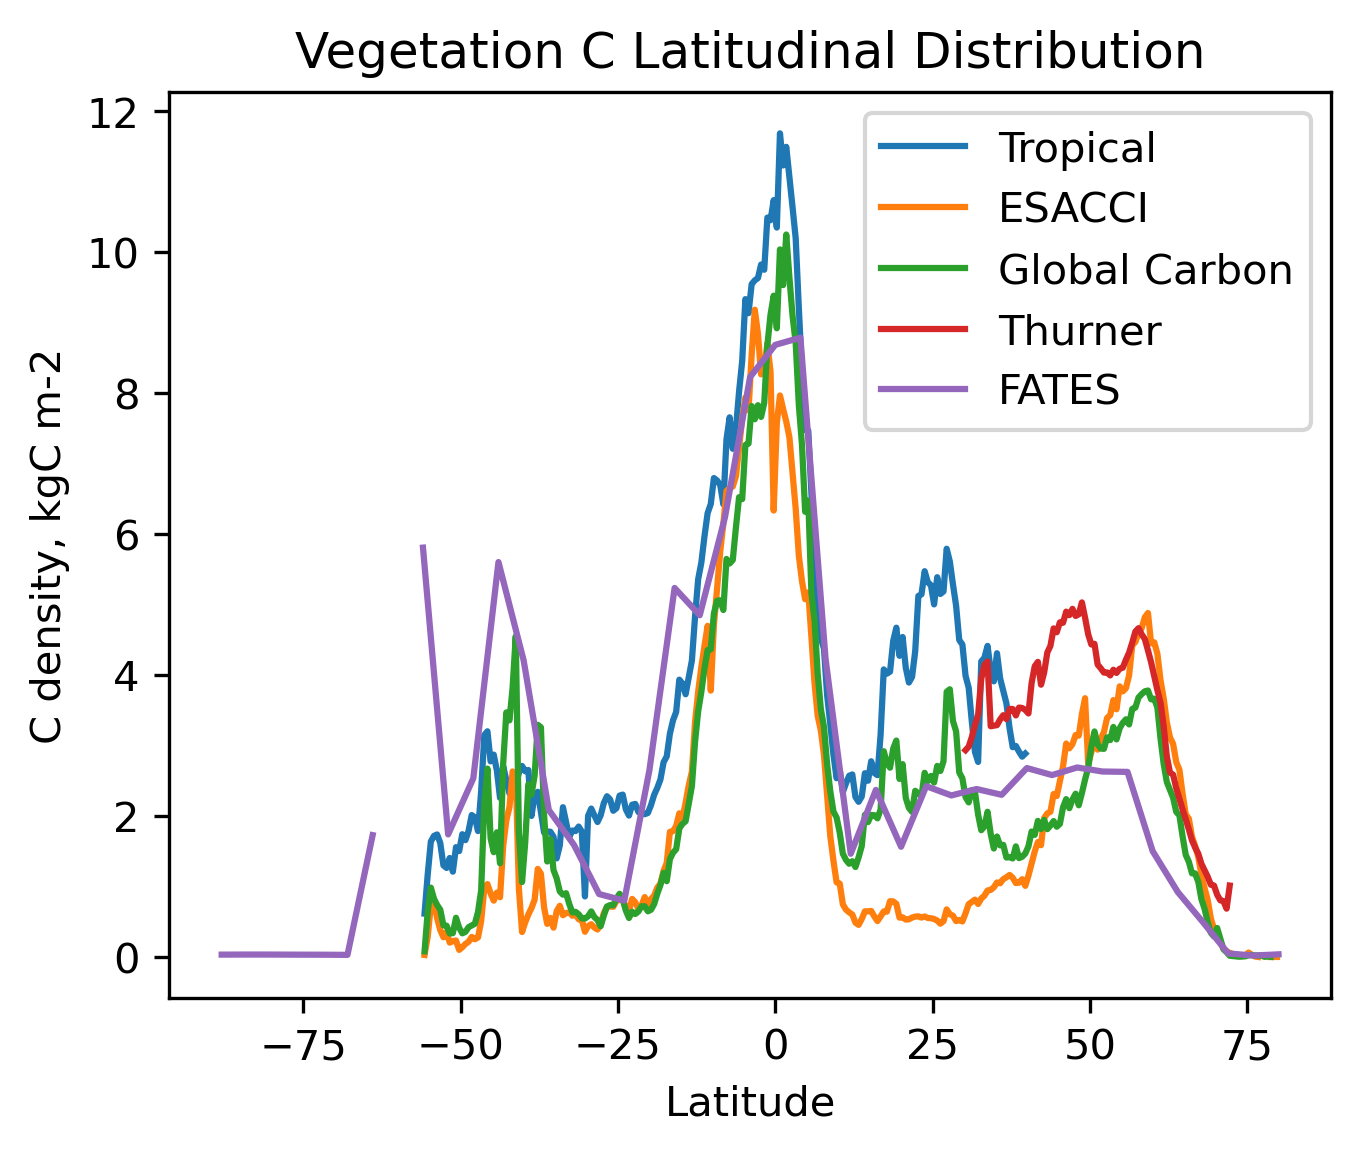

In [15]:
# Biomass C density
figure(figsize=(5, 4), dpi=300)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-60.25, 80.25, 0.5)
x3 = np.arange(-92, 92, 4)
plt.plot(x1, tropical_lat)
plt.plot(x2, esacci_lat*0.1)
plt.plot(x1, gc_lat)
# plt.plot(x1, nbcd2000_lat)
# plt.plot(x1, usf_lat)
plt.plot(x1, thurner_lat)
plt.plot(x3, vegc_all_lat)
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'Thurner', 'FATES'])
plt.title('Vegetation C Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('C density, kgC m-2')
# plt.ylim([0, 15])
plt.savefig('BiomassC_den_comparison_obs.png')

In [ ]:
# Total biomass C (Need to revise the impact from grid area)
x1 = np.arange(-89.75, 90.25, 0.5)
x2 = np.arange(-60.25, 80.25, 0.5)
x3 = np.arange(-92, 92, 4)
plt.plot(x1, tropical_lat_tot)
plt.plot(x2, esacci_lat_tot*0.1)
plt.plot(x1, gc_lat_tot)
# plt.plot(x1, nbcd2000_lat_tot)
# plt.plot(x1, usf_lat_tot)
plt.plot(x1, thurner_lat_tot)
plt.plot(x3, vegc_all_lat_tot)
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner'])
# plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'NBCD2000', 'US Forest', 'Thurner', 'FATES'])
plt.legend(['Tropical', 'ESACCI', 'Global Carbon', 'Thurner', 'FATES'])
plt.title('Biomass C Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('C density, kgC m-2')
# plt.ylim([0, 15])
plt.savefig('BiomassC_comparison_obs.png')

In [ ]:
# detected issues with FATES totvegc and per pft vegc output
plt.plot(vegc_lat)
plt.plot(vegc_lat_for)
plt.plot(vegc_all_lat)
plt.legend(['Total biomass C from FATES_VEGC_PF', 'Forest biomass C from FATES_VEGC_PF', 'Total biomass C from FATES_VEGC'])
plt.title('Biomass C Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('C density, kgC m-2')
plt.savefig('BiomassC_for_vs_grass.png')

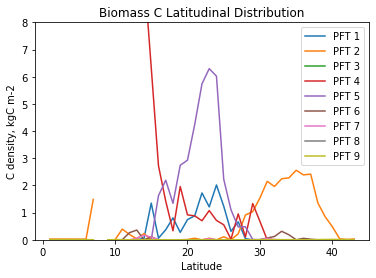

In [16]:
# detected issues with FATES totvegc and per pft vegc output
plt.plot(vegc_1_lat)
plt.plot(vegc_2_lat)
plt.plot(vegc_3_lat)
plt.plot(vegc_4_lat)
plt.plot(vegc_5_lat)
plt.plot(vegc_6_lat)
plt.plot(vegc_7_lat)
plt.plot(vegc_8_lat)
plt.plot(vegc_9_lat)

plt.legend(['PFT 1', 'PFT 2', 'PFT 3', 'PFT 4', 'PFT 5', 'PFT 6', 'PFT 7', 'PFT 8', 'PFT 9'])
plt.title('Biomass C Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('C density, kgC m-2')
plt.ylim([0, 8])
plt.savefig('BiomassC_for_vs_grass.png')

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:23: RuntimeWar

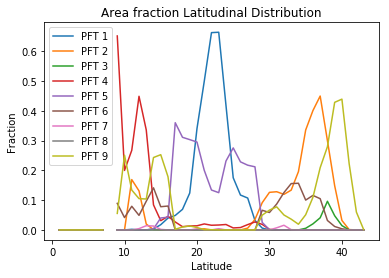

In [12]:
# Check PFT area latitudinal distribution (no-comp mode only)
area_pf_copy = copy.deepcopy(area_pf_nocomp)
area_pf_copy[area_pf_copy>1e2] = np.float('nan')
area_pf_copy[area_pf_copy<0] = np.float('nan')

area_1 = area_pf_copy[(12*nyr-1),0,:,:]
area_2 = area_pf_copy[(12*nyr-1),1,:,:]
area_3 = area_pf_copy[(12*nyr-1),2,:,:]
area_4 = area_pf_copy[(12*nyr-1),3,:,:]
area_5 = area_pf_copy[(12*nyr-1),4,:,:]
area_6 = area_pf_copy[(12*nyr-1),5,:,:]
area_7 = area_pf_copy[(12*nyr-1),6,:,:]
area_8 = area_pf_copy[(12*nyr-1),7,:,:]
area_9 = area_pf_copy[(12*nyr-1),8,:,:]

area_1_lat = np.nanmean(area_1, 1)
area_2_lat = np.nanmean(area_2, 1)
area_3_lat = np.nanmean(area_3, 1)
area_4_lat = np.nanmean(area_4, 1)
area_5_lat = np.nanmean(area_5, 1)
area_6_lat = np.nanmean(area_6, 1)
area_7_lat = np.nanmean(area_7, 1)
area_8_lat = np.nanmean(area_8, 1)
area_9_lat = np.nanmean(area_9, 1)

# detected issues with FATES totvegc and per pft vegc output
plt.plot(area_1_lat)
plt.plot(area_2_lat)
plt.plot(area_3_lat)
plt.plot(area_4_lat)
plt.plot(area_5_lat)
plt.plot(area_6_lat)
plt.plot(area_7_lat)
plt.plot(area_8_lat)
plt.plot(area_9_lat)

plt.legend(['PFT 1', 'PFT 2', 'PFT 3', 'PFT 4', 'PFT 5', 'PFT 6', 'PFT 7', 'PFT 8', 'PFT 9'])
plt.title('Area fraction Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.savefig('Area_per_PFT.png')

In [ ]:
# Check GPP per PFT area latitudinal distribution (no-comp mode only)
gpp_pf_copy = copy.deepcopy(gpp_pf)
gpp_pf_copy[gpp_pf_copy>1e2] = np.float('nan')
gpp_pf_copy[gpp_pf_copy<0] = np.float('nan')

gpp_1 = gpp_pf_copy[(12*nyr-1),0,:,:]
gpp_2 = gpp_pf_copy[(12*nyr-1),1,:,:]
gpp_3 = gpp_pf_copy[(12*nyr-1),2,:,:]
gpp_4 = gpp_pf_copy[(12*nyr-1),3,:,:]
gpp_5 = gpp_pf_copy[(12*nyr-1),4,:,:]
gpp_6 = gpp_pf_copy[(12*nyr-1),5,:,:]
gpp_7 = gpp_pf_copy[(12*nyr-1),6,:,:]
gpp_8 = gpp_pf_copy[(12*nyr-1),7,:,:]
gpp_9 = gpp_pf_copy[(12*nyr-1),8,:,:]
gpp_10 = gpp_pf_copy[(12*nyr-1),9,:,:]
gpp_11 = gpp_pf_copy[(12*nyr-1),10,:,:]
gpp_12 = gpp_pf_copy[(12*nyr-1),11,:,:]

gpp_1_lat = np.nanmean(gpp_1, 1)
gpp_2_lat = np.nanmean(gpp_2, 1)
gpp_3_lat = np.nanmean(gpp_3, 1)
gpp_4_lat = np.nanmean(gpp_4, 1)
gpp_5_lat = np.nanmean(gpp_5, 1)
gpp_6_lat = np.nanmean(gpp_6, 1)
gpp_7_lat = np.nanmean(gpp_7, 1)
gpp_8_lat = np.nanmean(gpp_8, 1)
gpp_9_lat = np.nanmean(gpp_9, 1)
gpp_10_lat = np.nanmean(gpp_10, 1)
gpp_11_lat = np.nanmean(gpp_11, 1)
gpp_12_lat = np.nanmean(gpp_12, 1)

figure(figsize=(5, 4), dpi=300)

# detected issues with FATES totvegc and per pft vegc output
plt.plot(gpp_1_lat)
plt.plot(gpp_2_lat)
plt.plot(gpp_3_lat)
plt.plot(gpp_4_lat)
plt.plot(gpp_5_lat)
plt.plot(gpp_6_lat)
plt.plot(gpp_7_lat)
plt.plot(gpp_8_lat)
plt.plot(gpp_9_lat)
plt.plot(gpp_10_lat)
plt.plot(gpp_11_lat)
plt.plot(gpp_12_lat)

plt.legend(['PFT 1', 'PFT 2', 'PFT 3', 'PFT 4', 'PFT 5', 'PFT 6', 'PFT 7', 'PFT 8', 'PFT 9', 'PFT 10', 'PFT 11', 'PFT 12'])
plt.title('GPP Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('GPP, kgC m-2 s-1')
plt.savefig('GPP_per_PFT.png')


In [ ]:
# Changes of the grass percentage
# Get the latitudinal mean of the forest biomass of all datasets
vegc_pf_copy = copy.deepcopy(vegc_pf)
vegc_pf_copy[vegc_pf_copy>1e2] = np.float('nan')
vegc_pf_copy[vegc_pf_copy<0] = np.float('nan')
vegc_fates = np.sum(vegc_pf_copy[0,0:12,:,:], 0)
vegc_fates_for = np.sum(vegc_pf_copy[0,1:2,:,:], 0)
vegc_copy = copy.deepcopy(vegc)
vegc_copy[vegc_copy>1e2] = np.float('nan')
vegc_copy[vegc_copy<0] = np.float('nan')
vegc_fates_all = vegc_copy[0,:,:]

# FATES
vegc_lat_ori = np.nanmean(vegc_fates, 1)
vegc_lat_for_ori = np.nanmean(vegc_fates_for, 1)
vegc_all_lat_ori = np.nanmean(vegc_fates_all, 1)

# detected issues with FATES totvegc and per pft vegc output
plt.plot(vegc_lat_ori)
plt.plot(vegc_lat)
plt.plot(vegc_lat_for_ori)
plt.plot(vegc_lat_for)
plt.legend(['Total biomass C, 1870', 'Total biomass C, 2000', 'Forest biomass C, 1870', 'Forest biomass C, 2000'])
plt.title('Biomass C Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('C density, kgC m-2')

### Detection of sites not reaching steady state

In [ ]:
# Loop over each site. Check the change of 5-year averaged biomass for the last 10 year is 
# higher than 5% of the total biomass for both forest and grass
vegc_for_bef = np.nanmean(np.nansum(vegc_pf_copy[((nyr-4)*12-1):(nyr*12-1),0:9,:,:], 1), 0)
vegc_for_aft = np.nanmean(np.nansum(vegc_pf_copy[((nyr-14)*12-1):((nyr-10)*12-1),0:9,:,:], 1), 0)
vegc_gra_bef = np.nanmean(np.nansum(vegc_pf_copy[((nyr-4)*12-1):(nyr*12-1),9:12,:,:], 1), 0)
vegc_gra_aft = np.nanmean(np.nansum(vegc_pf_copy[((nyr-14)*12-1):((nyr-10)*12-1),9:12,:,:], 1), 0)
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        # Only list sites with vegc > 5kgC m-2
        if(vegc_for_aft[i,j]>5):
            delta_vegc_for = (vegc_for_aft[i,j]-vegc_for_bef[i,j])/vegc_for_aft[i,j]          
            if(np.abs(delta_vegc_for)>0.05):
                print('Forest not in steady state:')
                print('nlat', i)
                print('nlon', j)
for i in np.arange(0, nlat):
    for j in np.arange(0, nlon):
        # Only list sites with vegc > 5kgC m-2
        if(vegc_gra_aft[i,j]>5):
            delta_vegc_gra = (vegc_gra_aft[i,j]-vegc_gra_bef[i,j])/vegc_for_aft[i,j]
            if(np.abs(delta_vegc_gra)>0.05):
                print('Grass not in steady state:')
                print('nlat', i)
                print('nlon', j)
                

### Biomass change, a site case

In [ ]:
# Get the latitudinal mean of the forest biomass of all datasets
lat_id = 26
lon_id = 25
vegc_pf_copy = copy.deepcopy(vegc_pf)
vegc_pf_copy[vegc_pf_copy>1e2] = np.float('nan')
vegc_pf_copy[vegc_pf_copy<0] = np.float('nan')
vegc_fates_for_ts = np.sum(vegc_pf_copy[:,0:9,lat_id,lon_id], 1)
vegc_fates_gra_ts = np.sum(vegc_pf_copy[:,9:12,lat_id,lon_id], 1)

# plot
plt.plot(vegc_fates_for_ts)
plt.plot(vegc_fates_gra_ts)
plt.legend(['Forest biomass C TS', 'Grass biomass C TS'])
plt.title('Biomass C, Normal Spinup')
plt.xlabel('Months after 1850-01')
plt.ylabel('C density, kgC m-2')

### NPlant, a site case

In [ ]:
lat_id = 26
lon_id = 25
np_pf_copy = copy.deepcopy(np_pf)
np_sz_copy = copy.deepcopy(np_sz)
np_for_ts = np.sum(np_pf_copy[:,0:9,lat_id,lon_id], 1)
np_gra_ts = np.sum(np_pf_copy[:,9:12,lat_id,lon_id], 1)
np_young_ts = np.sum(np_sz_copy[:,0:1,lat_id,lon_id], 1)
np_mature_ts = np.sum(np_sz_copy[:,1:14,lat_id,lon_id], 1)
figure(figsize=(5, 4), dpi=300)
plt.plot(np_for_ts, 'b-')
plt.plot(np_gra_ts, 'b--')
plt.plot(np_young_ts, 'k-')
plt.plot(np_mature_ts, 'k--')
plt.ylim([0, 2.5])
plt.legend(['Number of Plants, Forest', 'Number of Plants, Grass', 'Number of Plants, Young (sz_class=1)', 'Number of Plants, Mature (sz_class>1)'])
plt.title('Forest vs. Grass N plant')
plt.xlabel('Months after 1850-01')
plt.ylabel('Number of Plants, # m-2 yr-1')
plt.savefig('Nplant_young_mature.png')

### Recruitment, a site case

In [ ]:
lat_id = 26
lon_id = 25
recru_pf_copy = copy.deepcopy(recru_pf) 
recru_for_ts = np.sum(recru_pf_copy[:,0:9,lat_id,lon_id], 1)
recru_gra_ts = np.sum(recru_pf_copy[:,9:12,lat_id,lon_id], 1)
figure(figsize=(5, 4), dpi=180)
plt.plot(recru_for_ts, 'b-')
plt.plot(recru_gra_ts, 'b--')

# plt.ylim([-0.0001, 0.0001])

plt.legend(['Recruitment rate TS, Forest', 'Recruitment rate TS, Forest, Grass',])
plt.title('Forest vs. Grass recruitment rate')
plt.xlabel('Months after 1850-01')
plt.ylabel('Recruitment rate, # m-2 yr-1')
plt.savefig('Recruitment.png')

### Seed Germination (Germination output from FATES is actually the pool size after subtracting newly recruited C mass)

In [ ]:
lat_id = 26
lon_id = 25
sg_copy = copy.deepcopy(sg)
sg_ts = sg_copy[:,0,lat_id,lon_id]*3600*24*365
# plot
figure(figsize=(5, 4), dpi=180)
plt.plot(sg_ts, 'b-')
# plt.ylim([-6e-26, 6e-26])
plt.legend(['Germinated seeds TS, Mature'])
plt.title('Germinated seeds C flux')
plt.xlabel('Months after 1850-01')
plt.ylabel('C flux, kgC m-2 yr-1')

### Mortality, a site case

In [ ]:
lat_id = 26
lon_id = 25
age_mort_copy = copy.deepcopy(age_mort) 
back_mort_copy = copy.deepcopy(back_mort)
starv_mort_copy = copy.deepcopy(starv_mort)
freeze_mort_copy = copy.deepcopy(freeze_mort)
hydra_mort_copy = copy.deepcopy(hydra_mort)
scene_mort_copy = copy.deepcopy(scene_mort)

age_mort_for_ts = np.sum(age_mort_copy[:,1:13,lat_id,lon_id], 1)
age_mort_gra_ts = np.sum(age_mort_copy[:,0:1,lat_id,lon_id], 1)
back_mort_for_ts = np.sum(back_mort_copy[:,1:13,lat_id,lon_id], 1)
back_mort_gra_ts = np.sum(back_mort_copy[:,0:1,lat_id,lon_id], 1)
starv_mort_for_ts = np.sum(starv_mort_copy[:,1:13,lat_id,lon_id], 1)
starv_mort_gra_ts = np.sum(starv_mort_copy[:,0:1,lat_id,lon_id], 1)
freeze_mort_for_ts = np.sum(freeze_mort_copy[:,1:13,lat_id,lon_id], 1)
freeze_mort_gra_ts = np.sum(freeze_mort_copy[:,0:1,lat_id,lon_id], 1)
hydra_mort_for_ts = np.sum(hydra_mort_copy[:,1:13,lat_id,lon_id], 1)
hydra_mort_gra_ts = np.sum(hydra_mort_copy[:,0:1,lat_id,lon_id], 1)
scene_mort_for_ts = np.sum(scene_mort_copy[:,1:13,lat_id,lon_id], 1)
scene_mort_gra_ts = np.sum(scene_mort_copy[:,0:1,lat_id,lon_id], 1)

# plot
figure(figsize=(5, 4), dpi=180)
plt.plot(age_mort_for_ts, 'b-')
plt.plot(age_mort_gra_ts, 'b--')
plt.plot(back_mort_for_ts, 'r-')
plt.plot(back_mort_gra_ts, 'r--')
plt.plot(starv_mort_for_ts, 'k-')
plt.plot(starv_mort_gra_ts, 'k--')
plt.plot(freeze_mort_for_ts, 'y-')
plt.plot(freeze_mort_gra_ts, 'y--')
plt.plot(hydra_mort_for_ts, 'g-')
plt.plot(hydra_mort_gra_ts, 'g--')
plt.plot(scene_mort_for_ts, 'm-')
plt.plot(scene_mort_gra_ts, 'm--')

# plt.ylim([-0.01, 0.01])

plt.legend(['AGE Mort TS, Mature', 'AGE Mort TS, Young', 'BG Mort TS, Mature', 'BG Mort TS, Young', \
            'STARV Mort TS, Mature', 'STARV Mort TS, Young', 'FZ Mort TS, Mature', 'FZ Mort TS, Young', \
           'HYDRO Mort TS, Mature', 'HYDRO Mort TS, Young', 'SCENE Mort TS, Mature', 'SCENE Mort TS, Young',])
plt.title('Forest vs. Grass Mortality rate')
plt.xlabel('Months after 1850-01')
plt.ylabel('Mortality rate, # m-2 yr-1')
plt.savefig('Mortalities.png')

### Go forward and see the latitudinal distribution of N plant per PFT

In [ ]:
np_pf_copy = copy.deepcopy(np_pf)
np_pf_copy[np_pf_copy>1e10] = np.float('nan')
np_pf_copy[np_pf_copy<0] = np.float('nan')

np_1 = np_pf_copy[(12*nyr-1),0,:,:]
np_2 = np_pf_copy[(12*nyr-1),1,:,:]
np_3 = np_pf_copy[(12*nyr-1),2,:,:]
np_4 = np_pf_copy[(12*nyr-1),3,:,:]
np_5 = np_pf_copy[(12*nyr-1),4,:,:]
np_6 = np_pf_copy[(12*nyr-1),5,:,:]
np_7 = np_pf_copy[(12*nyr-1),6,:,:]
np_8 = np_pf_copy[(12*nyr-1),7,:,:]
np_9 = np_pf_copy[(12*nyr-1),8,:,:]
np_10 = np_pf_copy[(12*nyr-1),9,:,:]
np_11 = np_pf_copy[(12*nyr-1),10,:,:]
np_12 = np_pf_copy[(12*nyr-1),11,:,:]

np_1_lat = np.nanmean(np_1, 1)
np_2_lat = np.nanmean(np_2, 1)
np_3_lat = np.nanmean(np_3, 1)
np_4_lat = np.nanmean(np_4, 1)
np_5_lat = np.nanmean(np_5, 1)
np_6_lat = np.nanmean(np_6, 1)
np_7_lat = np.nanmean(np_7, 1)
np_8_lat = np.nanmean(np_8, 1)
np_9_lat = np.nanmean(np_9, 1)
np_10_lat = np.nanmean(np_10, 1)
np_11_lat = np.nanmean(np_11, 1)
np_12_lat = np.nanmean(np_12, 1)


In [ ]:
# detected issues with FATES totvegc and per pft vegc output
figure(figsize=(5, 4), dpi=300)
plt.plot(np_1_lat)
plt.plot(np_2_lat)
plt.plot(np_3_lat)
plt.plot(np_4_lat)
plt.plot(np_5_lat)
plt.plot(np_6_lat)
plt.plot(np_7_lat)
plt.plot(np_8_lat)
plt.plot(np_9_lat)
plt.plot(np_10_lat)
plt.plot(np_11_lat)
plt.plot(np_12_lat)
# plt.ylim([0, 1])
# plt.ylim([0, 2.5])
plt.legend(['PFT 1', 'PFT 2', 'PFT 3', 'PFT 4', 'PFT 5', 'PFT 6', 'PFT 7', 'PFT 8', 'PFT 9', 'PFT 10', 'PFT11', 'PFT12'])
plt.title('NPlant Latitudinal Distribution')
plt.xlabel('Latitude')
plt.ylabel('Nplant, # m-2')
plt.savefig('NPlant_per_PFT.png')



### Global Pools and Fluxes Calculation

In [5]:
# Calculate global total
# Check the whole time series 

soilc_copy = copy.deepcopy(soilc[:,:,:])
vegc_copy = copy.deepcopy(vegc[:,:,:])
litterc_copy = copy.deepcopy(litterc[:,:,:])
structc_copy = copy.deepcopy(structc[:,:,:])
nonstructc_copy = copy.deepcopy(nonstructc[:,:,:])
leafc_copy = copy.deepcopy(leafc[:,:,:])

gpp_copy = copy.deepcopy(gpp[:,:,:])
npp_copy = copy.deepcopy(npp[:,:,:])
hr_copy = copy.deepcopy(hr[:,:,:])
nbp_copy = copy.deepcopy(nbp[:,:,:])
nep_copy = copy.deepcopy(nep[:,:,:])
litc_in_copy = copy.deepcopy(litc_in[:,:,:])
litc_out_copy = copy.deepcopy(litc_out[:,:,:])

tot_len = nyr * 12
tot_soilc = np.zeros((tot_len))
tot_vegc = np.zeros((tot_len))
tot_litterc = np.zeros((tot_len))
tot_structc = np.zeros((tot_len))
tot_nonstructc = np.zeros((tot_len))
tot_leafc = np.zeros((tot_len))
tot_gpp = np.zeros((tot_len))
tot_npp = np.zeros((tot_len))
tot_nep = np.zeros((tot_len))
tot_nbp = np.zeros((tot_len))
tot_hr = np.zeros((tot_len))
tot_litc_in = np.zeros((tot_len))
tot_litc_out = np.zeros((tot_len))

for i in np.arange(0, tot_len):
    # Mask can only applied to each 2D slice
    tmp = soilc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_soilc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = vegc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_vegc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = litterc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litterc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = structc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_structc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12

    tmp = nonstructc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nonstructc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = leafc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_leafc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = gpp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_gpp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = npp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_npp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = nep_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nep[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12

    tmp = nbp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nbp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e15
    
    tmp = hr_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_hr[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_in_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_in[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_out_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_out[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2

In [ ]:
plt.plot(tot_soilc, 'k-')
plt.plot(tot_vegc, 'g-')
plt.plot(tot_litterc, 'r-')
plt.plot(tot_structc, 'y-')
plt.plot(tot_nonstructc, 'b-')
plt.plot(tot_leafc, 'm-')
plt.legend(['SoilC', 'VegC', 'LitterC', 'StructC', 'NonstructC', 'LeafC'])
plt.xlabel('Months since 1850')
plt.ylabel('C Pools (PgC)')
# plt.ylim([0, 400])
plt.savefig('Major_C_pools.png')

Text(0,0.5,'C fluxes (PgC yr-1)')

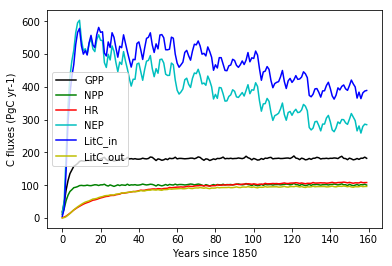

In [7]:
# Calculate annual fluxes
tot_len = nyr * 12
tot_ann_gpp = np.zeros((nyr))
tot_ann_npp = np.zeros((nyr))
tot_ann_hr = np.zeros((nyr))
tot_ann_litc_in = np.zeros((nyr))
tot_ann_litc_out = np.zeros((nyr))
tot_ann_nep = np.zeros((nyr))

for i in np.arange(0, nyr):
    tot_ann_gpp[i] = np.nanmean(tot_gpp[(i*12):((i+1)*12)])
    tot_ann_npp[i] = np.nanmean(tot_npp[(i*12):((i+1)*12)])
    tot_ann_hr[i] = np.nanmean(tot_hr[(i*12):((i+1)*12)])
    tot_ann_litc_in[i] = np.nanmean(tot_litc_in[(i*12):((i+1)*12)])
    tot_ann_litc_out[i] = np.nanmean(tot_litc_out[(i*12):((i+1)*12)])
    tot_ann_nep[i] = np.nanmean(tot_nep[(i*12):((i+1)*12)])

# Check major C fluxes
plt.plot(tot_ann_gpp, 'k-')
plt.plot(tot_ann_npp, 'g-')
plt.plot(tot_ann_hr, 'r-')
plt.plot(tot_ann_nep + (tot_ann_litc_in-tot_ann_litc_out), 'c-')
plt.plot(tot_ann_litc_in, 'b-')
plt.plot(tot_ann_litc_out, 'y-')
plt.legend(['GPP', 'NPP', 'HR', 'NEP', 'LitC_in', 'LitC_out'])
plt.xlabel('Years since 1850')
plt.ylabel('C fluxes (PgC yr-1)')
# plt.ylim([0, 200])

In [ ]:
plt.plot(tot_fates_hr, 'r-')
plt.legend(['Heterotrophoic respiration (Zoom in view)'])
plt.xlabel('Month since 1880')
plt.ylabel('C Fluxes (PgC yr-1)')

In [ ]:
plt.plot(tot_soilc, 'r-')
plt.plot(tot_vegc, 'g-')
plt.legend(['Total Soil C (Zoom in view)', 'Total Veg C'])
plt.xlabel('Month since 1880')
plt.ylabel('C Pools (PgC )')

In [ ]:
veg_old = tot_vegc[0:tot_len-1]
veg_new = tot_vegc[1:tot_len]
diff_veg = veg_new - veg_old
plt.plot(tot_fates_npp-tot_lit_out, 'r-')
plt.plot(diff_veg*12, 'g-')
plt.legend(['NPP - Lit Out', 'Diff VegC'])
plt.xlabel('Month since 1880')
plt.ylabel('C Pools (PgC )')

### Global Maps

#### New cartopy method

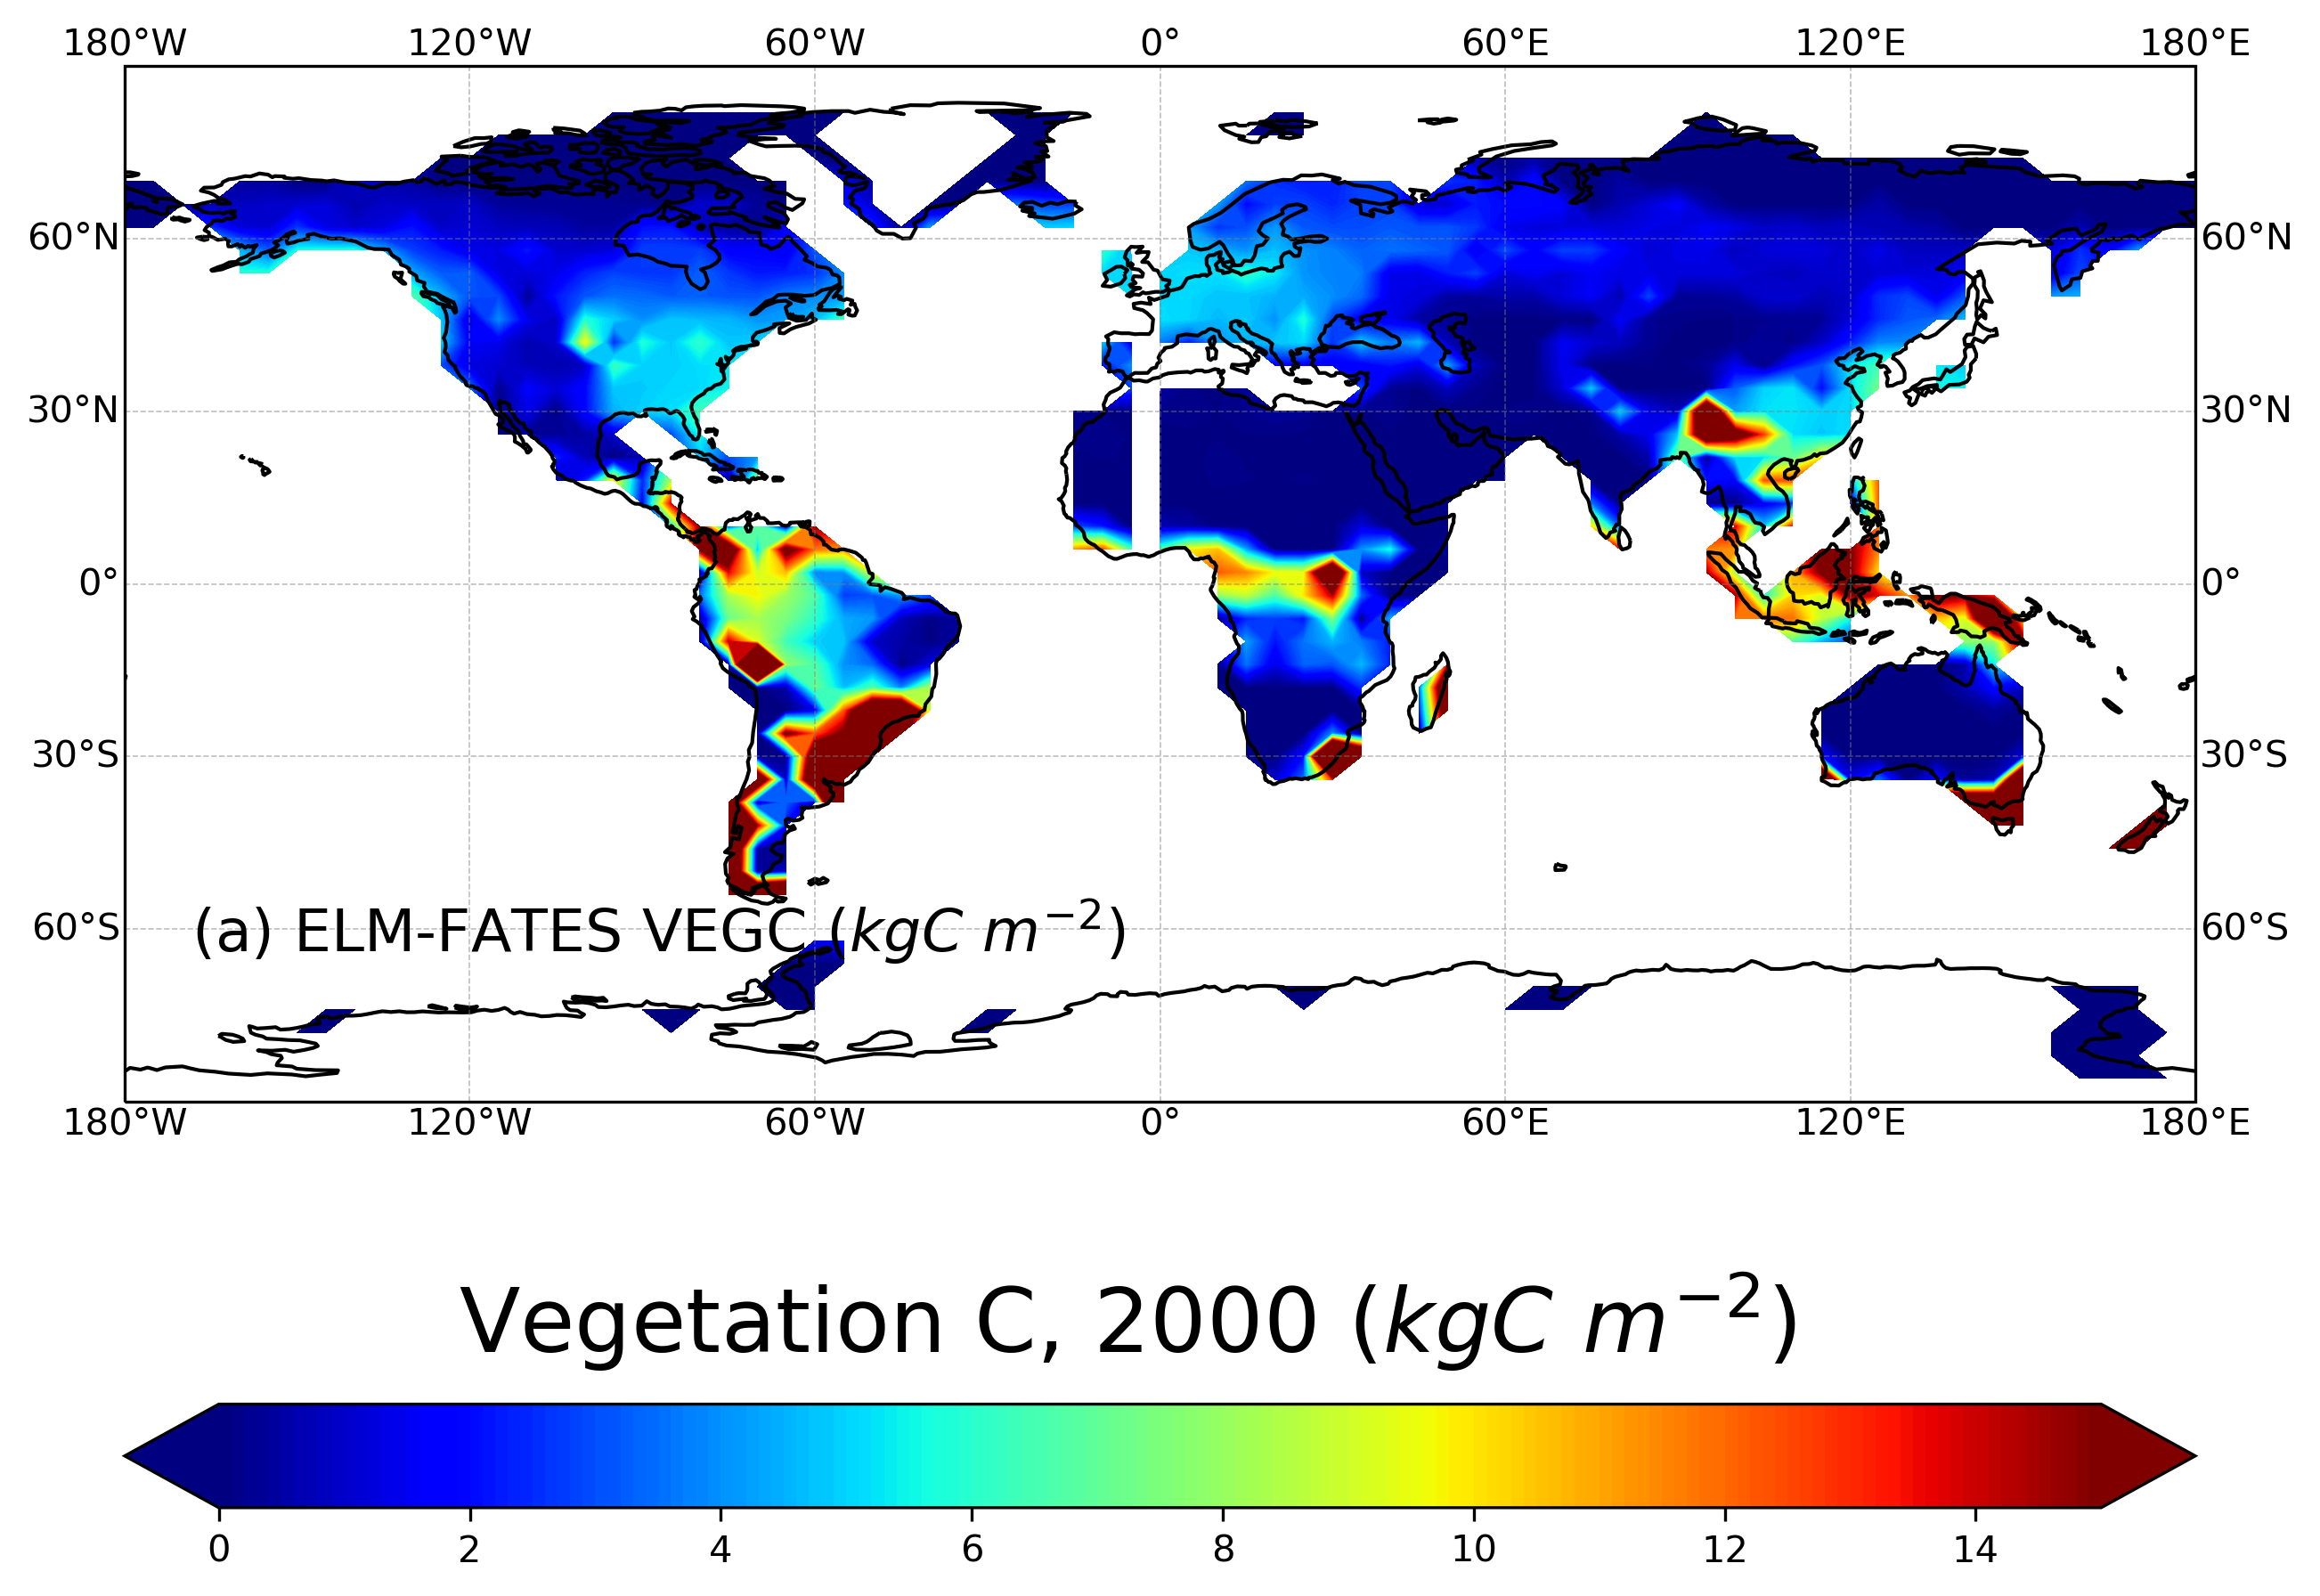

In [11]:
fig = plt.figure(figsize=(10,10), dpi=300)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, vegc[12*nyr-1,:,:], 60, levels=np.linspace(0.0, 15.0, 151), 
                  # locator=ticker.LogLocator(),  
             extend='both',transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

fig.text(0.25, 0.22, 'Vegetation C, 2000 ($kgC\ m^{-2}$)', fontsize=24)
fig.text(0.15, 0.37, '(a) ELM-FATES VEGC ($kgC\ m^{-2}$)', fontsize=16)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0] )
# plt.show()
plt.savefig('FATES_2000_VEGC.png')


C:\Users\Jay_S_000\AppData\Local\Temp\ipykernel_9752\3888025638.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gc_for_c_map[gc_for_c_map<=0] = np.float('nan')


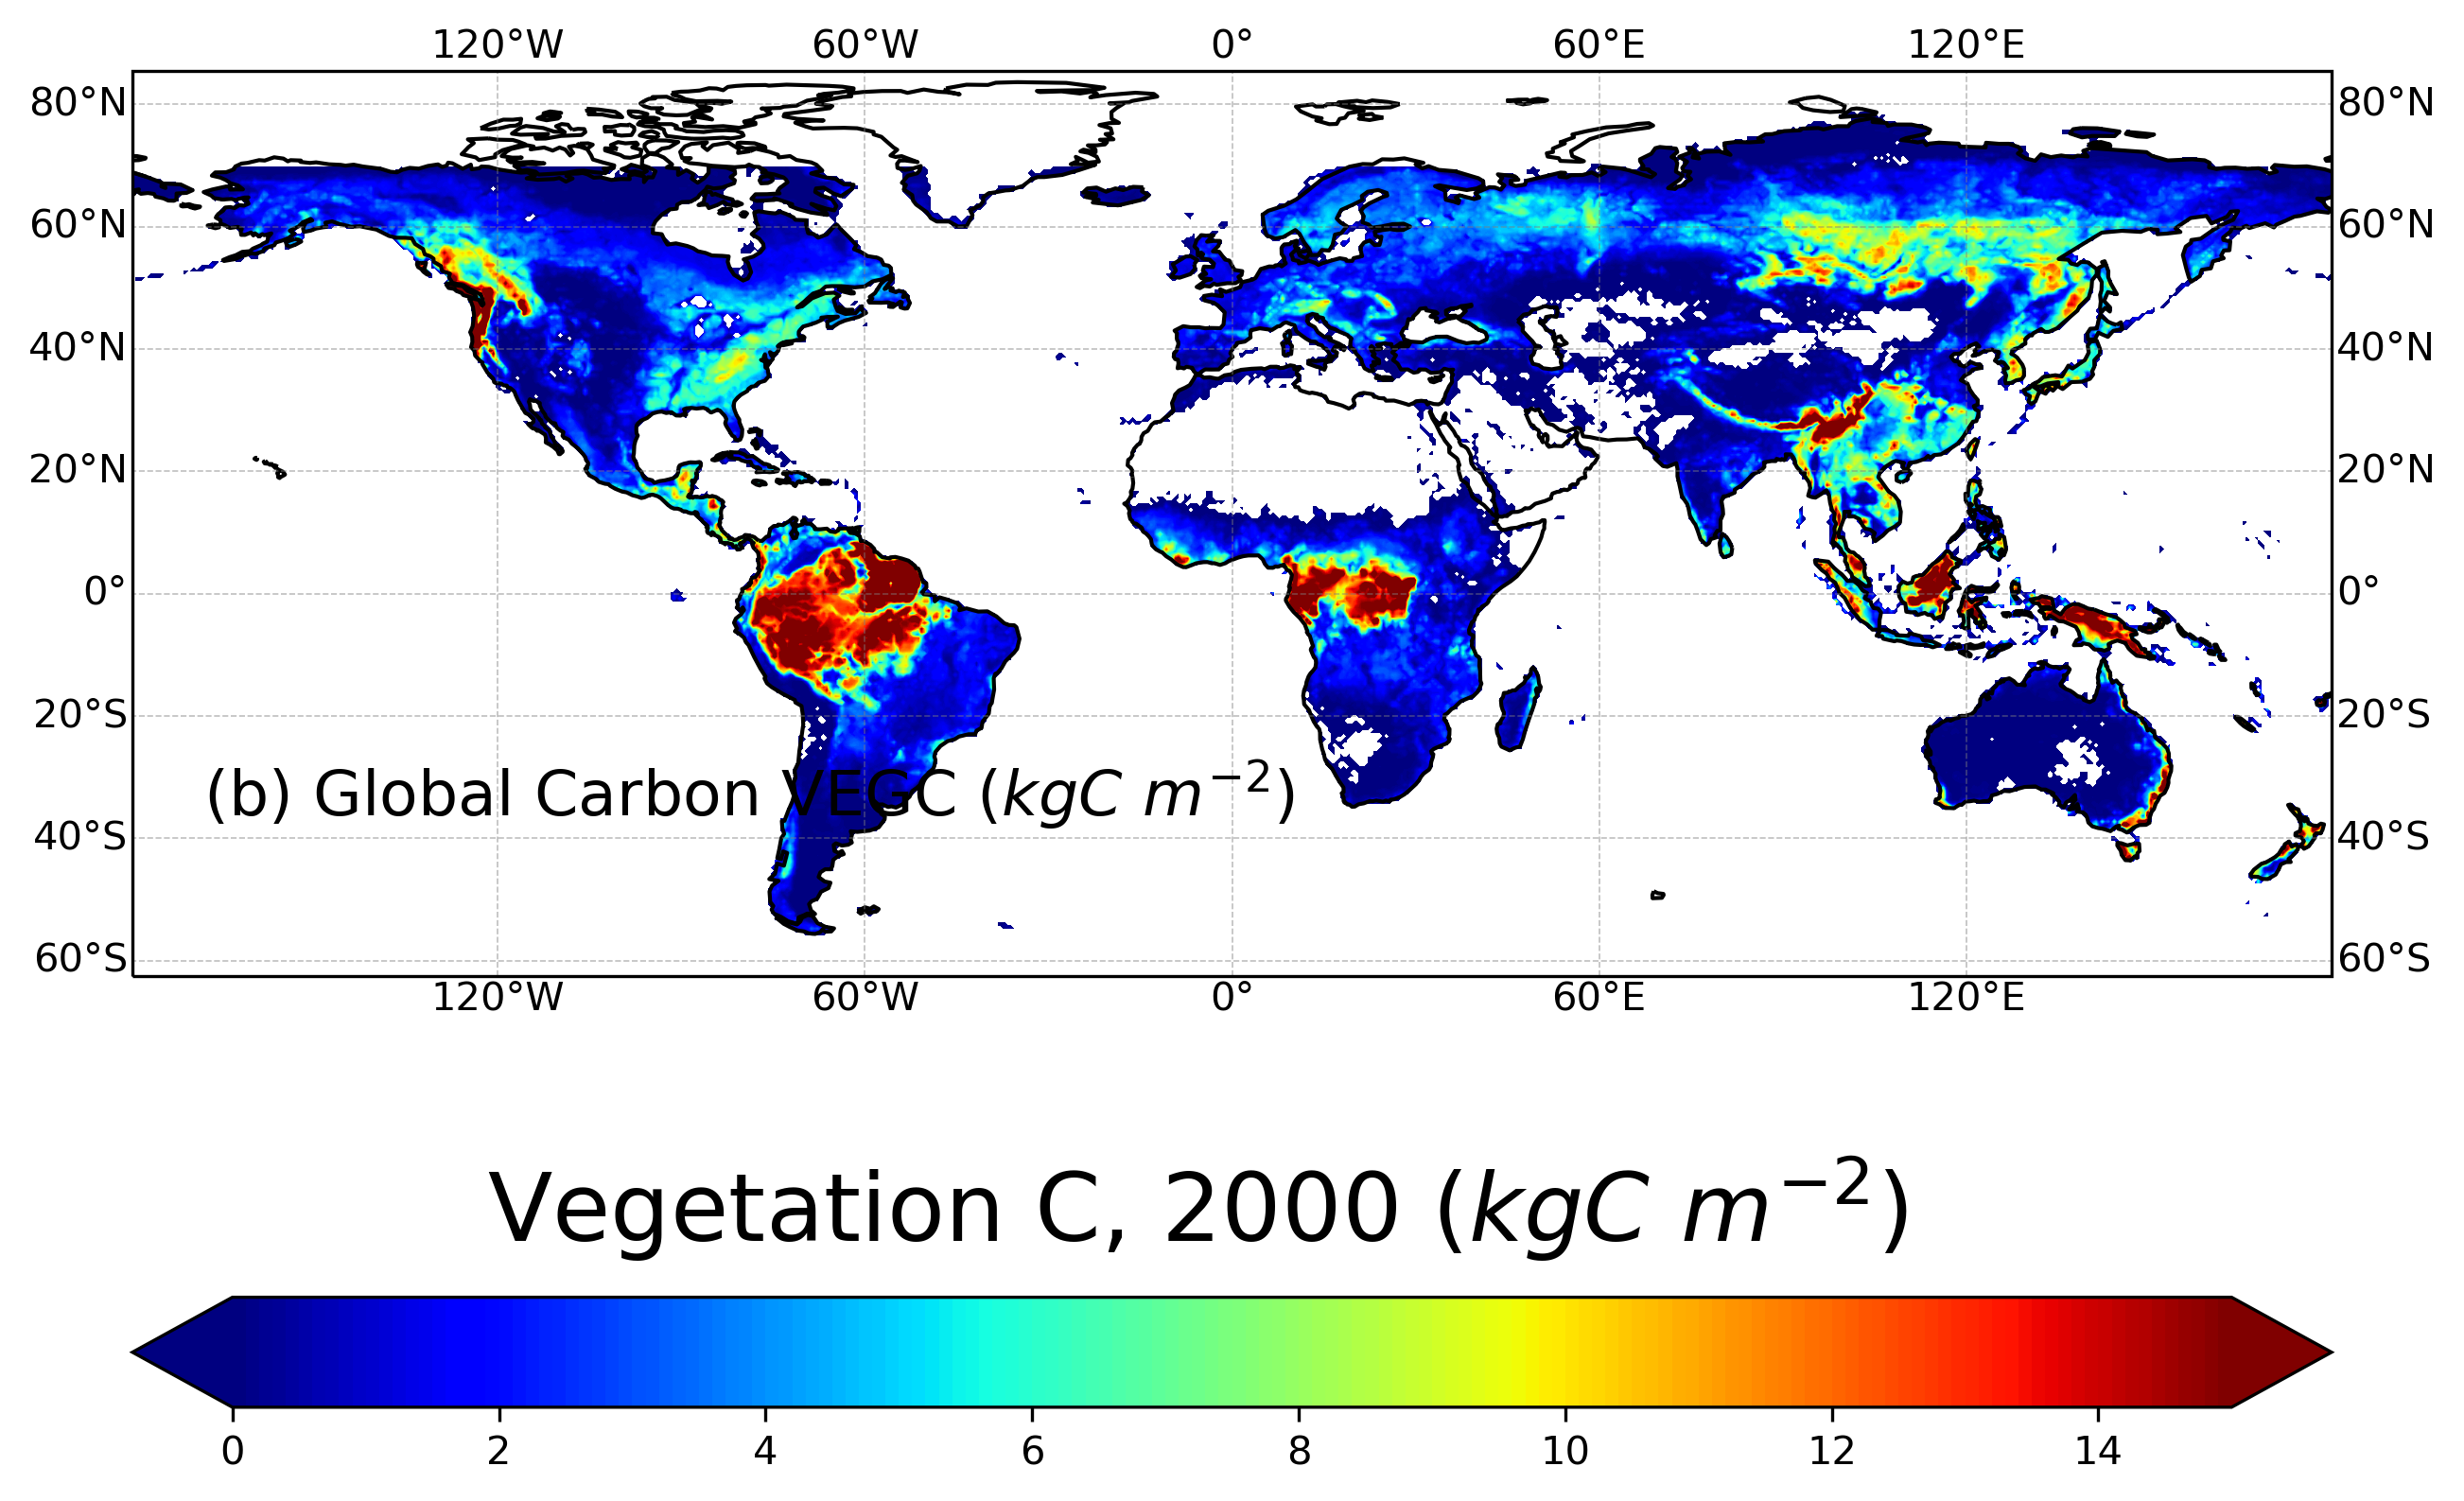

In [12]:
fig = plt.figure(figsize=(10,10), dpi=300)
gc_for_c_map = copy.deepcopy(gc_for_c)
ax = plt.axes(projection=ccrs.PlateCarree())

gc_for_c_map[gc_for_c_map<=0] = np.float('nan')
cs = plt.contourf(gc_lon, gc_lat, gc_for_c_map[:,:], 60, levels=np.linspace(0.0, 15.0, 151), 
                  # locator=ticker.LogLocator(),  
             extend='both',transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

fig.text(0.25, 0.22, 'Vegetation C, 2000 ($kgC\ m^{-2}$)', fontsize=24)
fig.text(0.15, 0.37, '(b) Global Carbon VEGC ($kgC\ m^{-2}$)', fontsize=16)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0] )
# plt.show()
plt.savefig('GC_2000_VEGC.png')

#### Get dominant PFT and make plots

In [21]:
## Uncomment only checking results from no competition mode.
# natpft = area_pf_nocomp[0,:,:,:]

# numpft = np.zeros((46,72))
# dompft = np.zeros((46,72))
# ## Calculate numbers of PFTs
# for i in np.arange(0,72):
#     for j in np.arange(0,46):
#         dominant_k = 1
#         if(np.sum(natpft[:,j,i])>0):
#             dompft[j,i] = 1
#         for k in np.arange(2,9):
#             if(natpft[k,j,i] > 0.0):
#                 numpft[j,i] = numpft[j,i] + 1
#             if(natpft[k,j,i]>natpft[dominant_k,j,i]):
#                 dominant_k = k
#                 dompft[j,i] = k

In [28]:
# Calculate dominant PFT from the crown area
natpft = cr_area_pf[nyr*12-1,:,:,:]

numpft = np.zeros((46,72))
dompft = np.zeros((46,72))
## Calculate numbers of PFTs
for i in np.arange(0,72):
    for j in np.arange(0,46):
        dominant_k = 1
        if(np.sum(natpft[:,j,i])>0):
            dompft[j,i] = 1
        for k in np.arange(2,9):
            if(natpft[k,j,i] > 0.0):
                numpft[j,i] = numpft[j,i] + 1
            if(natpft[k,j,i]>natpft[dominant_k,j,i]):
                dominant_k = k
                dompft[j,i] = k

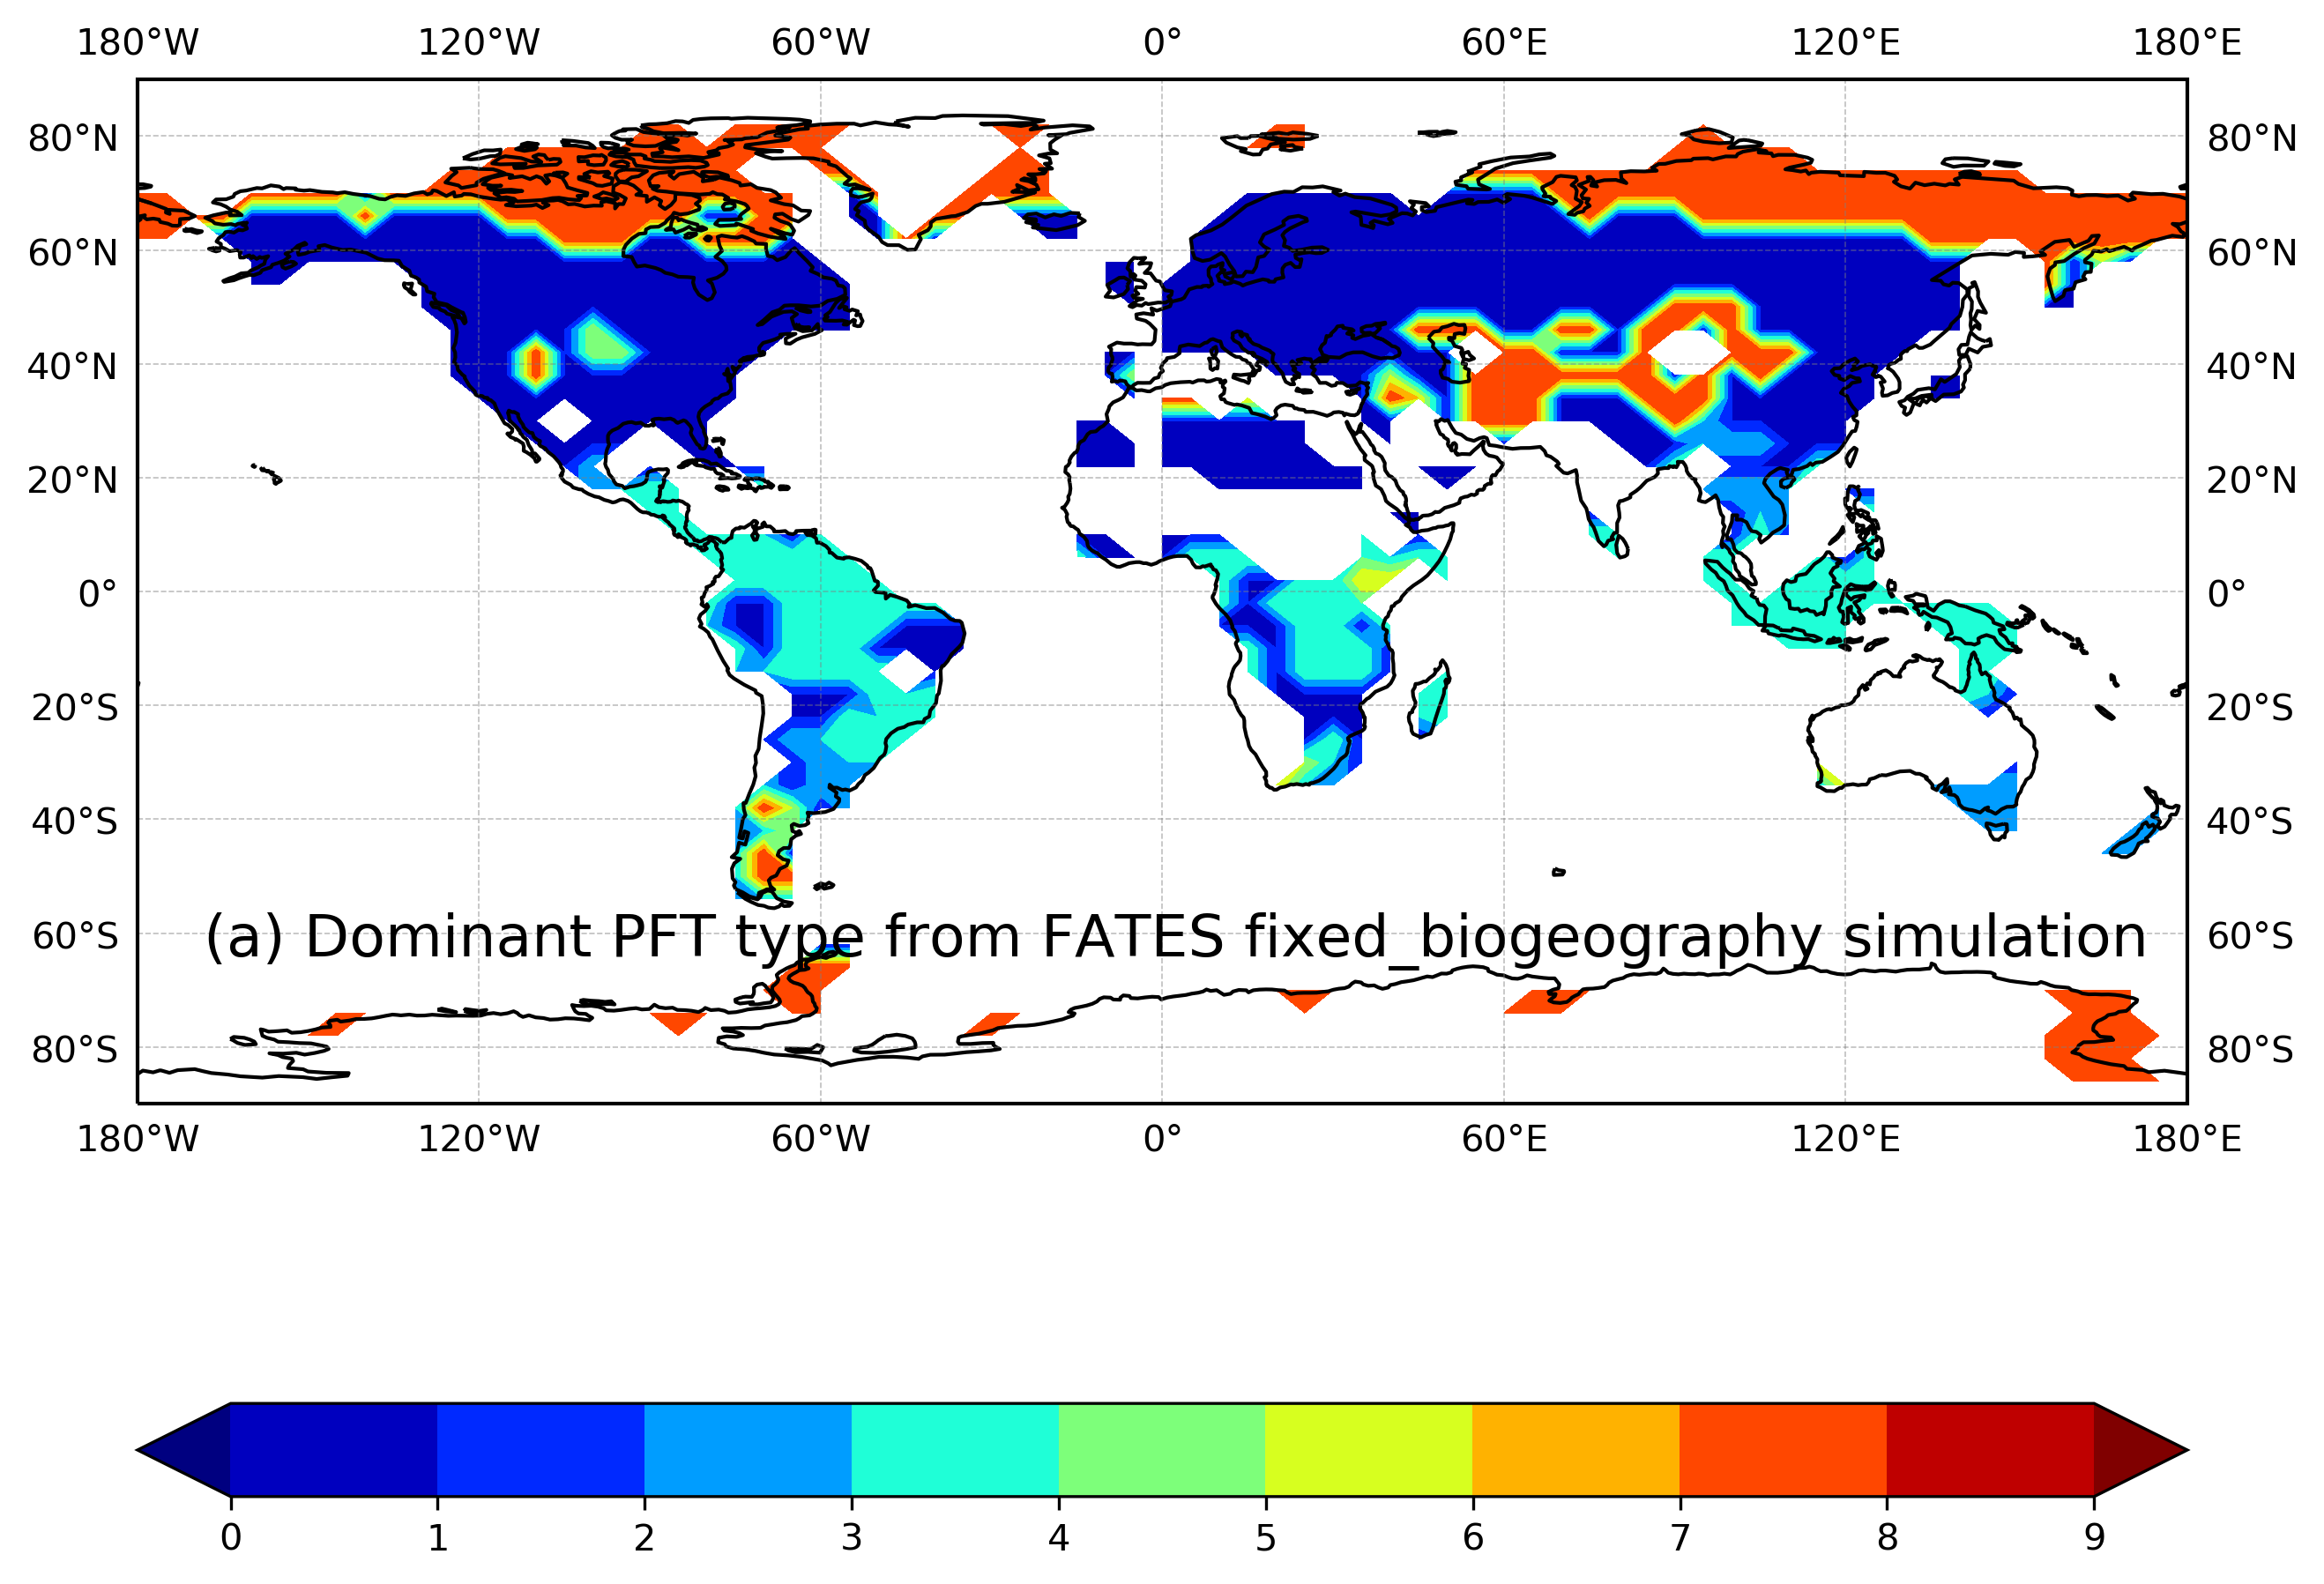

In [29]:
## Make plot
fig = plt.figure(figsize=(10,10), dpi=300)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

ax = plt.axes(projection=ccrs.PlateCarree())
dompft[dompft<=0] = np.float('nan')
cs = plt.contourf(lonnc_new, latnc_new, dompft[:,:], 60, levels=np.linspace(0.0, 9.0, 10), 
                  # locator=ticker.LogLocator(),  
             extend='both',transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# fig.text(0.25, 0.22, 'PFT types', fontsize=24)
fig.text(0.15, 0.37, '(a) Dominant PFT type from FATES fixed_biogeography simulation', fontsize=16)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal')
# plt.show()
plt.savefig('DPFT_FATES_2000.png')

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


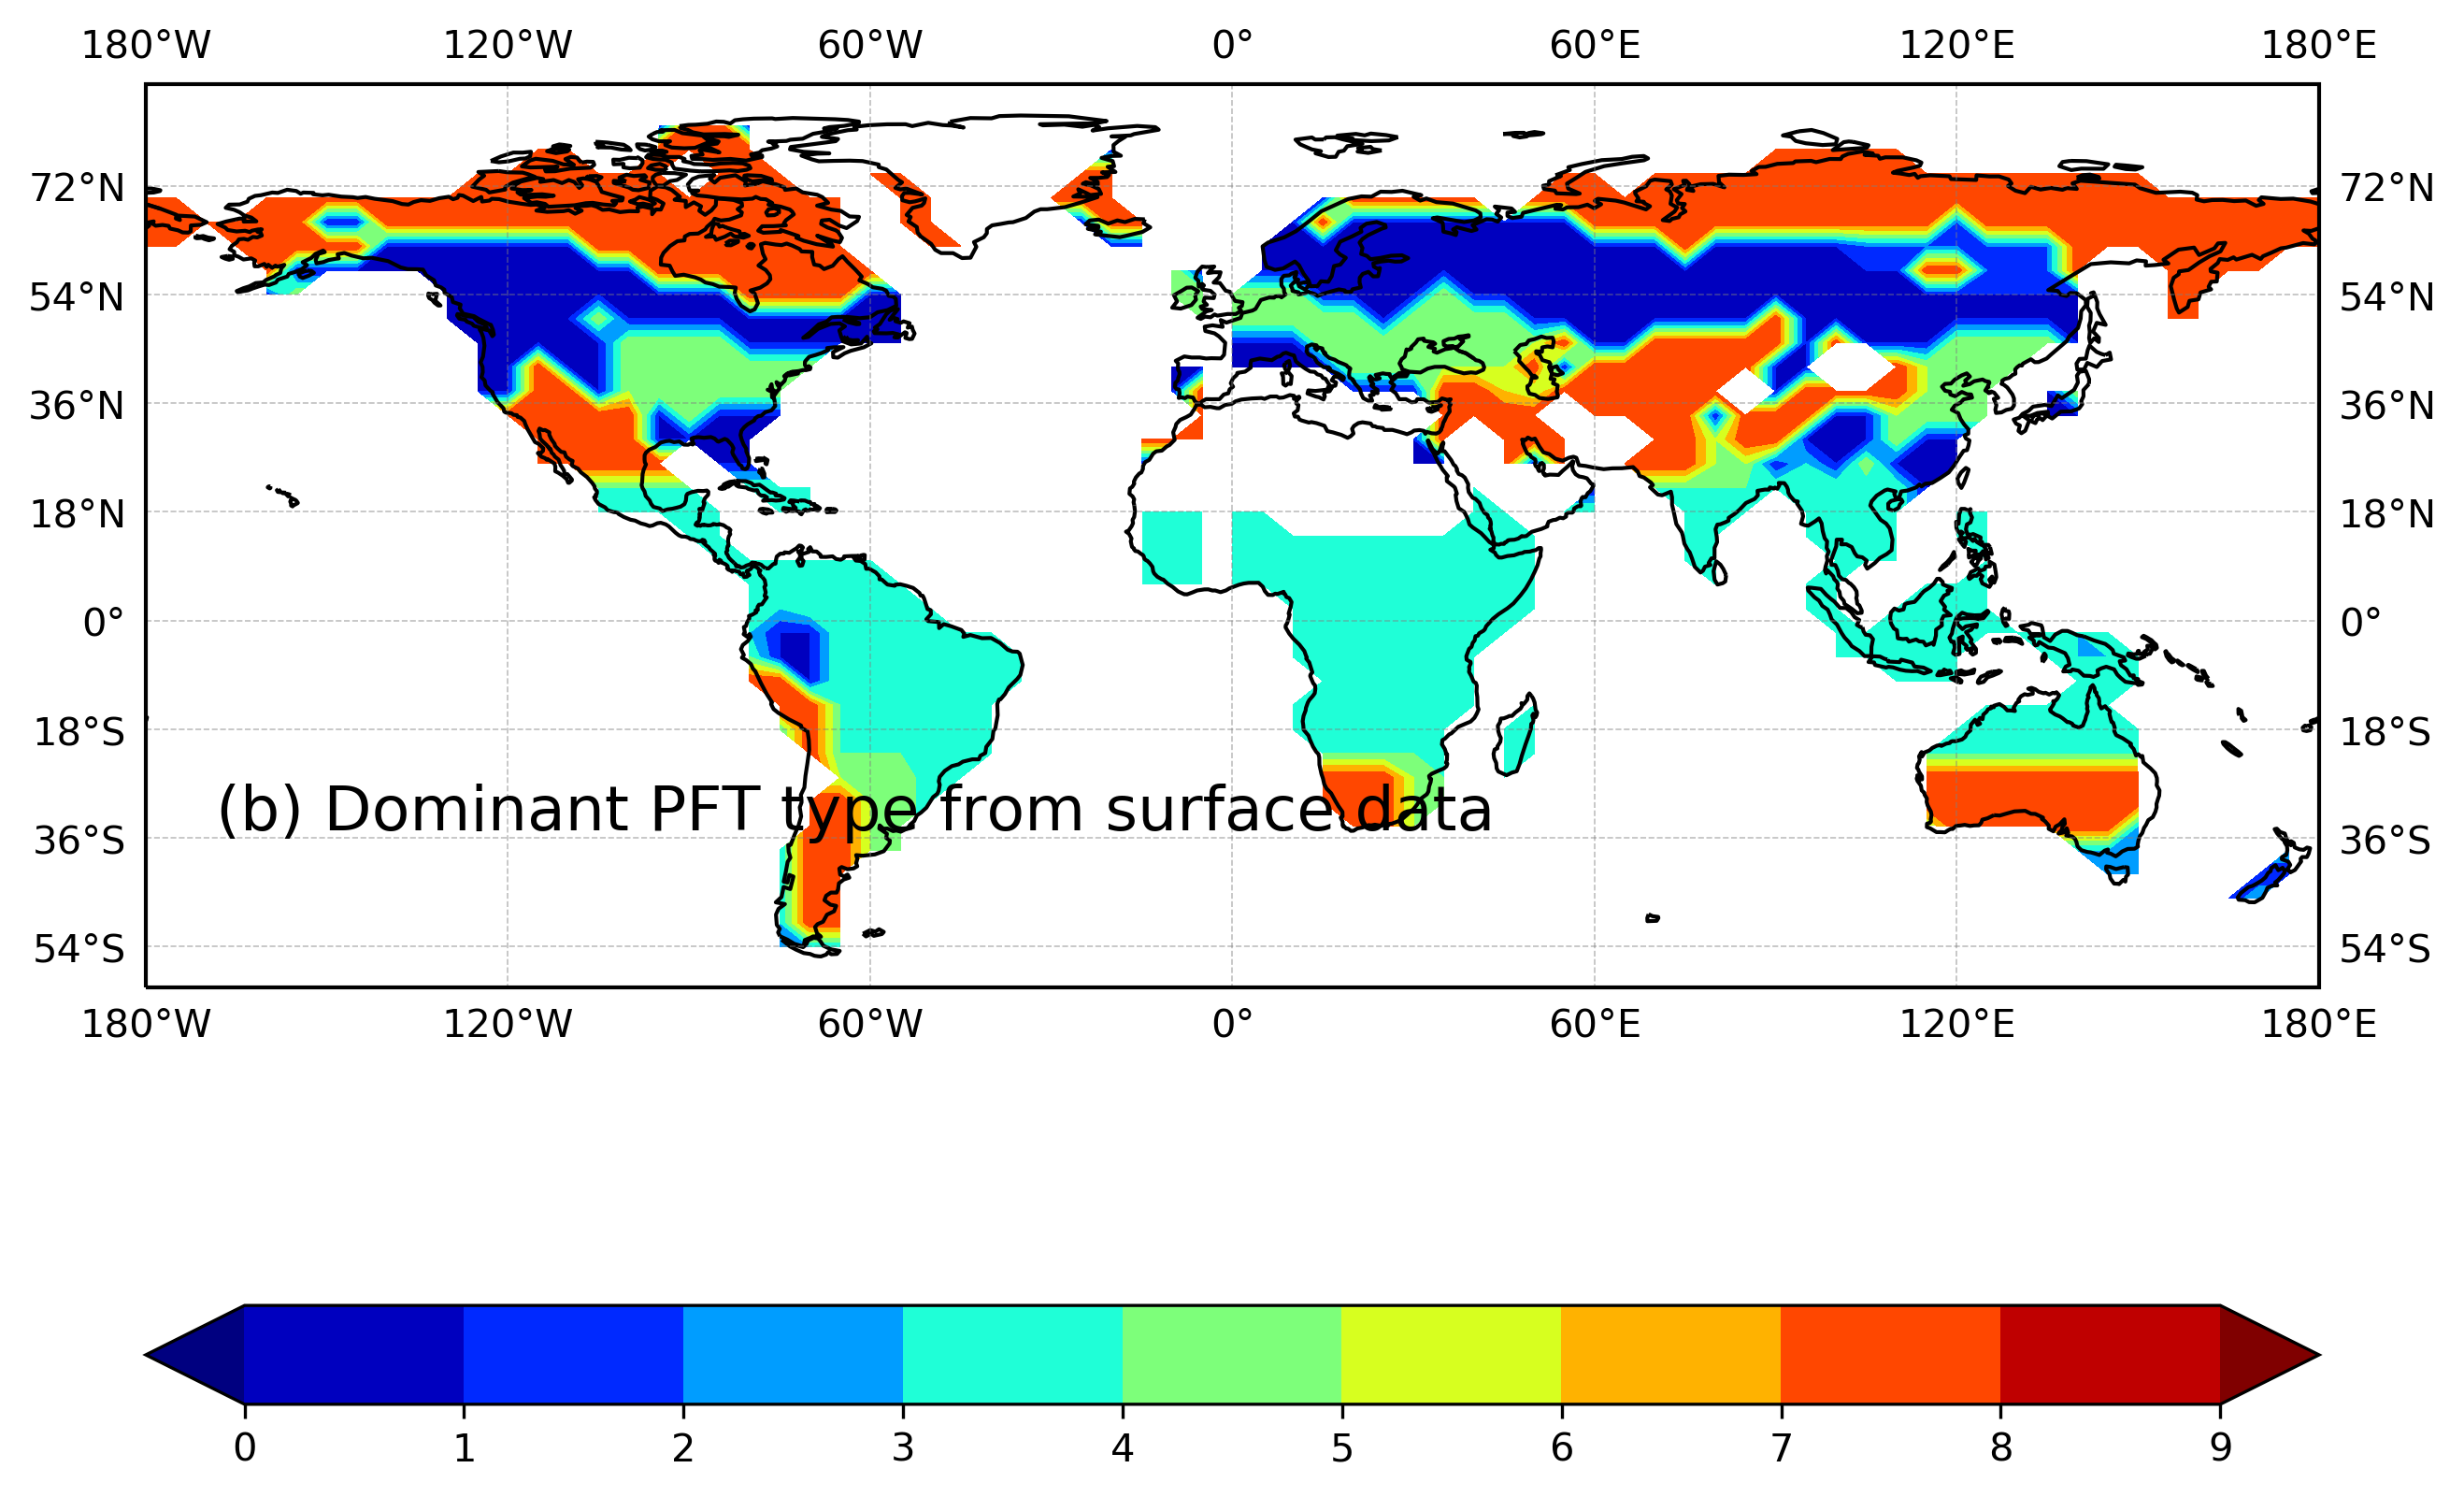

In [25]:
## Make plot of forcing biogeography map
fig = plt.figure(figsize=(10,10), dpi=300)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

ax = plt.axes(projection=ccrs.PlateCarree())
dompft[dompft<=0] = np.float('nan')
cs = plt.contourf(lonnc_new, latnc_new, dompft[:,:], 60, levels=np.linspace(0.0, 9.0, 10), 
                  # locator=ticker.LogLocator(),  
             extend='both',transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# fig.text(0.25, 0.22, 'PFT types', fontsize=24)
fig.text(0.15, 0.37, '(b) Dominant PFT type from surface data', fontsize=16)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal')
# plt.show()
plt.savefig('DPFT_2000.png')

#### Old basemap method

In [ ]:
# Plot comparison for secondary area vs. biomass (%)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,soilc[12*nyr-1,:,:]/1e3,
              norm=colors.LogNorm(vmin=1e-1, vmax=1e2),cmap=plt.cm.jet)#cmap=plt.get_cmap('Greens')) # use log color scale,
            # norm=colors.Normalize(vmin=0, vmax=20),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES soilc', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,vegc[12*nyr-1,:,:],
#              norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=10.0),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[0, 2, 4, 6, 8, 10],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Vegc ', fontsize=24)

plt.show()

In [ ]:
# Plot comparison for total vs. secondary (NPP, kgC m-2 month-1)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,gpp_ts[0,:,:]*3600*24*31,
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-2),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=0.5),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES NPP', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,gpp_sec[0,:,:]*3600*24*31,
#              norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=0.5),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary NPP', fontsize=24)

plt.show()

In [ ]:
# Plot comparison for total vs. secondary (Mortality rate, % of plant numbers, based on year-1)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,rmort_tot[:,:],
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-2),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=0.06),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES Mortalities', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,rmort_sec[:,:],
#              norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=0.06),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary Mortalities', fontsize=24)

plt.show()


In [ ]:
# Plot comparison for total vs. secondary (Mortality, plant numbers year-1)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,mort_tot[:,:],
              norm=colors.LogNorm(vmin=1e-2, vmax=1e1),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=0.06),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e-2, 1e-1, 1, 1e1],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES Mortalities', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,mort_sec[:,:],
             norm=colors.LogNorm(vmin=1e-2, vmax=1e1),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=0.06),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[1e-2, 1e-1, 1, 1e1],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary Mortalities', fontsize=24)

plt.show()

In [ ]:
# Plot comparison for total vs. secondary (Number of plants, #, based on year-1)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,forest_tot[:,:],
              norm=colors.LogNorm(vmin=1e-2, vmax=1e1),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=200),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e-2, 1e-1, 1, 1e1],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES plant number m-2', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,forest_sec[:,:],
             norm=colors.LogNorm(vmin=1e-2, vmax=1e1),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=200),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[1e-2, 1e-1, 1, 1e1],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary plant number m-2', fontsize=24)

plt.show()

In [ ]:
# Plot comparison for total vs. secondary (Number of cohorts, #, based on year-1)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,ncohorts[0,:,:],
              norm=colors.LogNorm(vmin=1, vmax=1e4),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=200),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1, 1e1, 1e2, 1e3, 1e4],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES Cohorts', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,ncohorts_sec[0,:,:],
             norm=colors.LogNorm(vmin=1, vmax=1e4),cmap=plt.cm.jet) # use log color scale,
#             norm=colors.Normalize(vmin=0, vmax=200),cmap=plt.cm.jet) # use log color scale

cbar2 = map.colorbar(cs2,ticks=[1, 1e1, 1e2, 1e3, 1e4],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary Cohorts', fontsize=24)

plt.show()

In [ ]:
# Secondary forest area map (in fraction)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,sec_frac[1919,:,:],
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-2),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1e-2, vmax=1),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e-2, 5e-2, 1e-1, 5e-1, 1],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES Secondary Fraction', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,sec_biomass[1919,:,:],
#              norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1, vmax=100),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1, 5, 10, 50, 100],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) FATES Secondary C', fontsize=24)

plt.show()
# plt.savefig('FATES_SEC.jpg',dpi=300)

In [ ]:
# Line plot secondary C vs. total C
biomass_day = copy.deepcopy(biomass_ts)
biomass_sec_day = copy.deepcopy(sec_biomass)

# Clear data with ocean mask
biomass_day[biomass_day>1e4] = np.float('nan')
biomass_sec_day[biomass_sec_day>1e4] = np.float('nan')

# New vars
biomass_yr = np.ones([nyr, 46, 72])*np.float('nan')
biomass_yr_sec = np.ones([nyr, 46, 72])*np.float('nan')
delta_biomass_sec = np.ones([nyr-1, 46, 72])*np.float('nan')

for iyr in np.arange(0,nyr):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    biomass_yr[iyr,:,:] = np.nanmean(biomass_day[id_beg:id_end,:,:])*area_4x5*nat_area_frac[0,:,:]*1e6
    biomass_yr_sec[iyr,:,:] = np.nanmean(biomass_sec_day[id_beg:id_end,:,:])*area_4x5*nat_area_frac[0,:,:]*1e6
    if(iyr > 0):
        delta_biomass_sec[iyr-1,:,:] = biomass_yr_sec[iyr,:,:] - biomass_yr_sec[iyr-1,:,:]

biomass_yr_tot = np.nansum(np.nansum(biomass_yr, 2), 1)/1e12
biomass_sec_yr_tot = np.nansum(np.nansum(biomass_yr_sec, 2), 1)/1e12
plt.plot(biomass_yr_tot, 'b-', linewidth=3)
plt.plot(biomass_sec_yr_tot, 'g--', linewidth=5)
plt.xlabel('Years since 1950')
plt.ylabel('Forest C ($PgC$)')
plt.legend(['Total', 'Secondary'])
plt.title('Check total C vs. secondary C')
plt.show()
# plt.savefig('validate_luc_frac_global.png')



In [ ]:
# Mask ocean
fates_hrv_c[fates_hrv_c>1e4] = np.float('nan')

# Secondary forest area map (in KgC)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,fates_hrv_c[1919,:,:]*1e-3*area_4x5*1e6*3600*24*365,
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) FATES', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,lu_hrv_c[159,:,:],
#              norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.43, '(b) LUH2', fontsize=24)

plt.show()
# plt.savefig('PRIM_HARV.jpg',dpi=300)

In [ ]:
# Check the total harvested C.
## Validate harvested C (gC m-2 yr-1). 
lu_hrv_c_tot = copy.deepcopy(lu_hrv_c)
lu_hrv_prim_c_tot = copy.deepcopy(lu_hrv_c-lu_hrv_c_sec)
fates_hrv_c_tot = np.zeros((nyr, 46, 72))

# Apply Mask 
# No cohorts
fates_hrv_c[fates_hrv_c>1] = np.float('nan')

for iyr in np.arange(0,nyr-1):
    # Middle of year
    id_beg = iyr*12+1
    # gC m-2 s-1 -> kg C
    fates_hrv_c_tot[iyr, :, :] = fates_hrv_c[id_beg,:,:]*1e-3*area_4x5*1e6*3600*24*365
    
hrv_c_luh2_yr_tot = np.nansum(np.nansum(lu_hrv_c_tot, 2), 1)/1e12
hrv_c_luh2_prim_yr_tot = np.nansum(np.nansum(lu_hrv_prim_c_tot, 2), 1)/1e12
hrv_c_fates_yr_tot = np.nansum(np.nansum(fates_hrv_c_tot, 2), 1)/1e12

plt.plot(hrv_c_fates_yr_tot[0:159], 'b-', linewidth=3)
plt.plot(hrv_c_luh2_prim_yr_tot[0:159], 'r--', linewidth=3)
plt.plot(hrv_c_luh2_yr_tot[0:159], 'g--', linewidth=5)
plt.xlabel('Years since 1850')
plt.ylabel('Harvested C (PgC yr-1)')
# plt.ylim([0, 0.8])
plt.legend(['FATES Harvested C', 'LUH2 Harvested C from Primary Lands', 'LUH2 Harvested C'])
plt.title('Validate harvested C')
plt.show()
# plt.savefig('validate_hrv_c_global.png')


In [ ]:
## Check VegC change for every year
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,delta_biomass[0,:,:],
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=-1, vmax=1),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[-1, -0.5, 0, 0.50, 1],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) 1851', fontsize=24)

ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,delta_biomass[158,:,:],
#              norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=-0.1, vmax=0.1),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[-0.1, -0.05, 0, 0.05, 0.1],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) 2009', fontsize=24)

plt.show()
# plt.savefig('DvegC.jpg',dpi=300)


In [ ]:
## Map to show what type of issue each gridcell has when logging is introduced.
# Check the total harvested C.
## Validate harvested C (gC m-2 yr-1). 
# reason_map = np.ones((46, 72))*np.float('nan')
biomass_init = biomass_ts[0,:,:]
ch_biomass = delta_biomass[58,:,:]*sec_frac[1919,:,:]*area_4x5*1e6
ch_hrv_debt_sec = hrv_debt_sec[1919,:,:] - hrv_debt_sec[1919,:,:]
hrv_req = lu_hrv_c_sec[160,:,:]
mature_area = area_age[1919, 6, :, :]
secbiomass_minus_hrv = sec_biomass[1919,:,:]*area_4x5*1e6 - lu_hrv_c_sh1[160,:,:] - lu_hrv_c_sh3[160,:,:]
ch_minus_req = ch_biomass*area_4x5*1e6 - ch_hrv_debt_sec
debt_mask = copy.deepcopy(hrv_debt_sec[1919,:,:])
debt_mask[debt_mask>1e15] = -9999.
sec_frac_mask = copy.deepcopy(sec_frac[1919,:,:])

# Apply Mask
# 0. Secondary forest did not reach maturity
reason_map = np.zeros((46, 72))

# 2. Low growth rate 
# Change of secondary biomass lower than the harvest rate
reason_map[ch_minus_req<0] = 2
# reason_map[secbiomass_minus_hrv>0] = 0

# 3. Too tiny secondary forest area (<1% of gridcell)
reason_map[sec_frac_mask<0.01] = 3

# 1. No cohorts survived
# Zero biomass grids with secondary forest harvest debt
reason_map[biomass_init==0] = 1

# Mask out area with no secondary forest harvest debt
reason_map[debt_mask<=0] = np.float('nan')


lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,reason_map,
#               norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),cmap=plt.get_cmap('Greens')) # use log color scale,
            norm=colors.Normalize(vmin=0, vmax=3),cmap=plt.cm.jet) # use log color scale

cbar = map.colorbar(cs1,ticks=[0, 1, 2, 3],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.63, '(a) Causes', fontsize=24)

# for iyr in np.arange(0,nyr-1):
#     # Middle of year
#     id_beg = iyr*12+1
#     # gC m-2 s-1 -> kg C
#     fates_hrv_c_tot[iyr, :, :] = fates_hrv_c[id_beg,:,:]*1e-3*area_4x5*1e6*3600*24*365
    
# hrv_c_luh2_yr_tot = np.nansum(np.nansum(lu_hrv_c_tot, 2), 1)/1e12
# hrv_c_fates_yr_tot = np.nansum(np.nansum(fates_hrv_c_tot, 2), 1)/1e12

# plt.plot(hrv_c_fates_yr_tot, 'b-', linewidth=3)
# plt.plot(hrv_c_luh2_yr_tot[0:40], 'g--', linewidth=5)
# plt.xlabel('Years since 1850')
# plt.ylabel('Harvested C (PgC yr-1)')
# plt.ylabel('Harvested C (PgC yr-1)')
# # plt.ylim([0, 0.8])
# plt.legend(['FATES Harvested C', 'LUH2 Harvested C'])
# plt.title('Validate harvested C')
plt.show()
# plt.savefig('causes.png')


In [ ]:
np.shape(area_age)

In [ ]:
21912-365

In [ ]:
hrv_debt_sec_cp = copy.deepcopy(hrv_debt_sec)
hrv_debt_sec_cp[hrv_debt_sec_cp>1e15] = np.float('nan')

# Biomass map
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,biomass_den[:,:],
              norm=colors.LogNorm(vmin=1, vmax=1e2),cmap=plt.cm.jet) # use log color scale,
cbar = map.colorbar(cs1,ticks=[1, 5, 10, 50, 100],location='bottom',pad="5%",extend='both')

# cs1 = map.pcolormesh(x,y,hrv_debt_sec[100,:,:],
#               norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale,
# cbar = map.colorbar(cs1,ticks=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')

# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.64, '(a) Biomass (in kgC m-2)', fontsize=24)

# Harvest debt map
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,hrv_debt_sec_cp[1919,:,:],
              norm=colors.LogNorm(vmin=1e6, vmax=1e11),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1e6, 1e7, 1e8, 1e9, 1e10, 1e11],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) Harvest debt in secondary patches (in KgC)', fontsize=24)

plt.show()
# plt.savefig('FATES_biomass_hrvdebt_global_map.png')

In [ ]:
np.shape(biomass_den)

In [ ]:
# Biomass plot
# Secondary forest area map
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,biomass_den[:,:],
              norm=colors.Normalize(vmin=0, vmax=20),cmap=plt.cm.jet) # use log color scale,

cbar = map.colorbar(cs1,ticks=[0, 4, 8, 12, 16, 20],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.85, '(a)', fontsize=24)

## Biomass den from LUH2?
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,biomass_den[3650,:,:]-biomass_den[0,:,:],
              norm=colors.Normalize(vmin=-1, vmax=1),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.43, '(b)', fontsize=24)

plt.show()
# plt.savefig('SEC_FRAC.jpg',dpi=300)



In [ ]:
############################################################
### WARNING: THIS CALCULATION CONSUME MUCH TIME
### DON'T RUN IT UNLESS YOU REALLY NEED RESULTS
### Check the output biomass data from FATES
### Dominant PFTs, number of PFTs from the surface data
############################################################
filename_in = 'extracted_chrv_1850s.nc'

fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin.variables['fates_levage'][:]

## define the sizes of each dimension
ntim = len(time)
nagebins = len(patch_age_bins)

## read in variables
sec_frac = fin.variables['FATES_SECONDARY_FOREST_FRACTION'][:]
biomass_age = fin.variables['FATES_VEGC_SZPF'][:]
area_age = fin.variables['FATES_PATCHAREA_AP'][:]
hrv_debt = fin.variables['HARVEST_DEBT'][:]
hrv_debt_sec = fin.variables['HARVEST_DEBT_SEC'][:]
hrv_flux10c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD10C'][:]
hrv_flux100c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD100C'][:]
# landfrac = fin.variables['landfrac'][:]

fin.close()

### Any biomass value higher than 0.01 shall be accounted
biomass_myr = np.nanmean(biomass_age, 0)
# biomass is in the dimension of size*pft
biomass_pft = np.zeros((12,46,72))
for i in np.arange(0,12):
    biomass_pft[i,:,:] = np.nansum(biomass_myr[(i-1)*13:i*13,:,:], 0)

numpft_fates = np.zeros((46,72))
dompft_fates = np.zeros((46,72))
## Calculate numbers of PFTs
for i in np.arange(0,72):
    for j in np.arange(0,46):
        dominant_k = 1
        for k in np.arange(1,12):
            if(biomass_pft[k,j,i] > 0.0):
                numpft_fates[j,i] = numpft_fates[j,i] + 1
            if(biomass_pft[k,j,i]>biomass_pft[dominant_k,j,i]):
                dominant_k = k
                dompft_fates[j,i] = k

### Plot to show number of PFTs and the dominant PFT
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,numpft_fates[:,:],
              norm=colors.Normalize(vmin=0, vmax=5),cmap=plt.cm.jet) # use log color scale,

cbar = map.colorbar(cs1,ticks=[0, 1, 2, 3, 4, 5],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.64, '(a) Number of PFTs - FATES', fontsize=24, color='White')

# Harvest debt map
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,dompft_fates[:,:],
              norm=colors.Normalize(vmin=0, vmax=6),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[0, 1, 2, 3, 4, 5, 6],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) Dominant PFT - FATES', fontsize=24, color='White')

# plt.show()
plt.savefig('fates_fixed_biogeog_map_global_4x5.png')